# periodo
Es el mes al que corresponde la foto
periodo 202504 son todas las ventas realizadas entre

20250401 00:00:00
20250430 23:59:59

customer_id
Es el numero unico que identica a un cliente, a uno de los ~550 clientes que posee la empresa, Cadenas de supermercados, Mayoristas y Distribuidores
Por supuesto hay clientes pequenos que en un mes dado no compran absolutamente nada

plan_precios_cuidados
Es una marca {0, 1} de si ese producto participa del Plan Precios Cuidados impulsado por el gobierno https://es.wikipedia.org/wiki/Precios_Cuidados

cust_request_qty
Es la cantidad de cajas que el cliente quizo comprar durante ese mes a La Multinacional, esto esta ya netado de ordenes caidas
La unidad minima de un pedido es 1 caja, la que por supuesto dependiendo del tamano del producto posee distinta cantidad de envases
Un cliente pone una orden y La Multinacional tiene aproximadamente tres dias para cumplirla (depende de que tan grande es el cliente, hay un Service Level Agreement distinto con cada cliente)
generalmente esa cantidad SI es honrada por La Multinacional

tn
Este es el principal campo del dataset
Es la cantidad REAL de toneladas vendidas de ese producto, a ese cliente, en ese periodo

cust_request_tn
Es simplemente cust_request_qty por el peso en toneladas de una caja de ese producto

product_id
identifica al producto

# Labo III
# Multinacional - Prediccion de Ventas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional for larger text and better visuals
sns.set(style="whitegrid", context="talk")

In [2]:
# Load the sales data (tab-delimited)
sales = pd.read_csv("../datasets/sell-in.txt", sep="\t", dtype={"periodo": str})

# Load the stocks data (tab-delimited)
stocks = pd.read_csv("../datasets/tb_stocks.txt", sep="\t", dtype={"periodo": str})

# Load the product information data (tab-delimited)
product_info = pd.read_csv("../datasets/tb_productos.txt", sep="\t")

In [3]:
print("Sales Data:")
print(sales.shape)
print(sales.head(), "\n")

print("Stocks Data:")
print(stocks.head(), "\n")

print("Product Info Data:")
print(product_info.head())


Sales Data:
(2945818, 7)
  periodo  customer_id  product_id  plan_precios_cuidados  cust_request_qty  \
0  201701        10234       20524                      0                 2   
1  201701        10032       20524                      0                 1   
2  201701        10217       20524                      0                 1   
3  201701        10125       20524                      0                 1   
4  201701        10012       20524                      0                11   

   cust_request_tn       tn  
0          0.05300  0.05300  
1          0.13628  0.13628  
2          0.03028  0.03028  
3          0.02271  0.02271  
4          1.54452  1.54452   

Stocks Data:
  periodo  product_id  stock_final
0  201810       20524      1.61267
1  201810       20311      2.93657
2  201810       20654      6.83269
3  201810       21005      1.01338
4  201810       20974      0.34595 

Product Info Data:
  cat1         cat2     cat3    brand  sku_size  product_id
0   HC  ROPA L

In [6]:
sales['periodo'] = pd.to_datetime(sales['periodo'], format='%Y%m')
stocks['periodo'] = pd.to_datetime(stocks['periodo'], format='%Y%m')


In [7]:
# MONTHLY SALES

# Group by month and product, summing total sales in tons
monthly_sales = (
    sales.groupby(['periodo', 'product_id'])['tn']
    .sum()
    .reset_index()
)


In [8]:
# Elimino duplicados, y cargo con cero los meses sin ventas de algun producto

# Unique months and products
all_periods = monthly_sales['periodo'].drop_duplicates()
all_products = monthly_sales['product_id'].drop_duplicates()

# Cartesian product of all months and products
full_index = pd.MultiIndex.from_product(
    [all_periods, all_products],
    names=['periodo', 'product_id']
)

# Reindex and fill missing sales with 0
full_sales = (
    monthly_sales.set_index(['periodo', 'product_id'])
    .reindex(full_index, fill_value=0)
    .reset_index()
)


In [9]:
print("Full Sales Matrix:")
print(full_sales.head())
print(f"Total rows (months × products): {len(full_sales)}")


Full Sales Matrix:
     periodo  product_id          tn
0 2017-01-01       20001   934.77222
1 2017-01-01       20002   550.15707
2 2017-01-01       20003  1063.45835
3 2017-01-01       20004   555.91614
4 2017-01-01       20005   494.27011
Total rows (months × products): 44388


In [10]:
# Merge stock_final into full_sales
data = full_sales.merge(stocks, on=['periodo', 'product_id'], how='left')

# Merge product info (static features)
data = data.merge(product_info, on='product_id', how='left')


In [9]:
print("Merged Dataset Preview:")
print(data.head())


Merged Dataset Preview:
     periodo  product_id          tn  stock_final   cat1         cat2  \
0 2017-01-01       20001   934.77222          NaN     HC  ROPA LAVADO   
1 2017-01-01       20002   550.15707          NaN     HC  ROPA LAVADO   
2 2017-01-01       20003  1063.45835          NaN  FOODS     ADEREZOS   
3 2017-01-01       20004   555.91614          NaN  FOODS     ADEREZOS   
4 2017-01-01       20005   494.27011          NaN  FOODS     ADEREZOS   

       cat3    brand  sku_size  
0   Liquido    ARIEL    3000.0  
1   Liquido  LIMPIEX    3000.0  
2  Mayonesa   NATURA     475.0  
3  Mayonesa   NATURA     240.0  
4  Mayonesa   NATURA     120.0  


## EDA

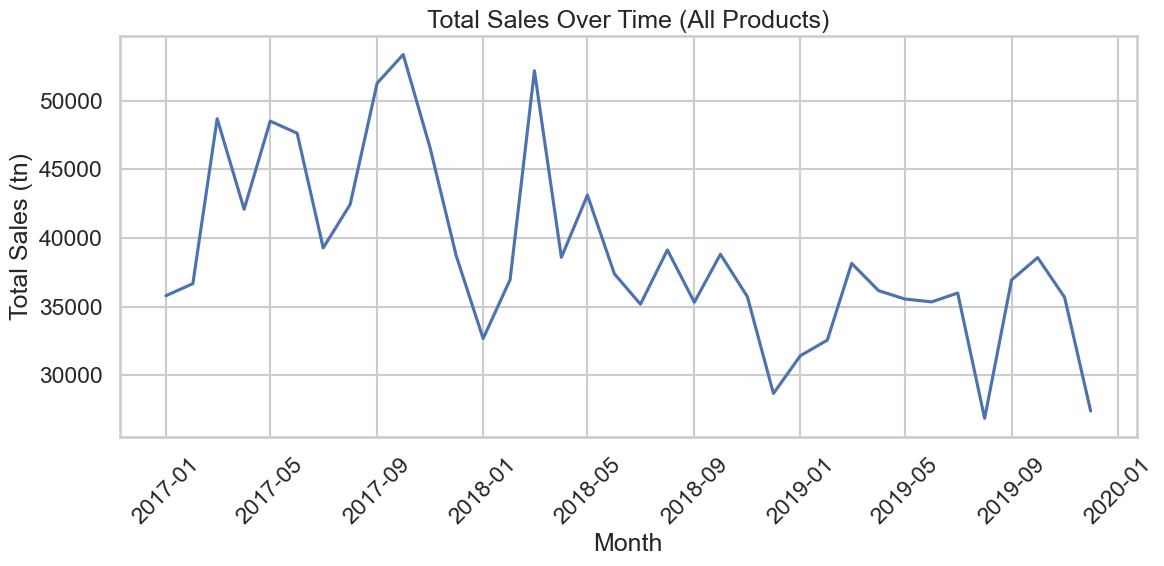

In [10]:
#Total sales by month

monthly_total = data.groupby('periodo')['tn'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_total, x='periodo', y='tn')
plt.title("Total Sales Over Time (All Products)")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


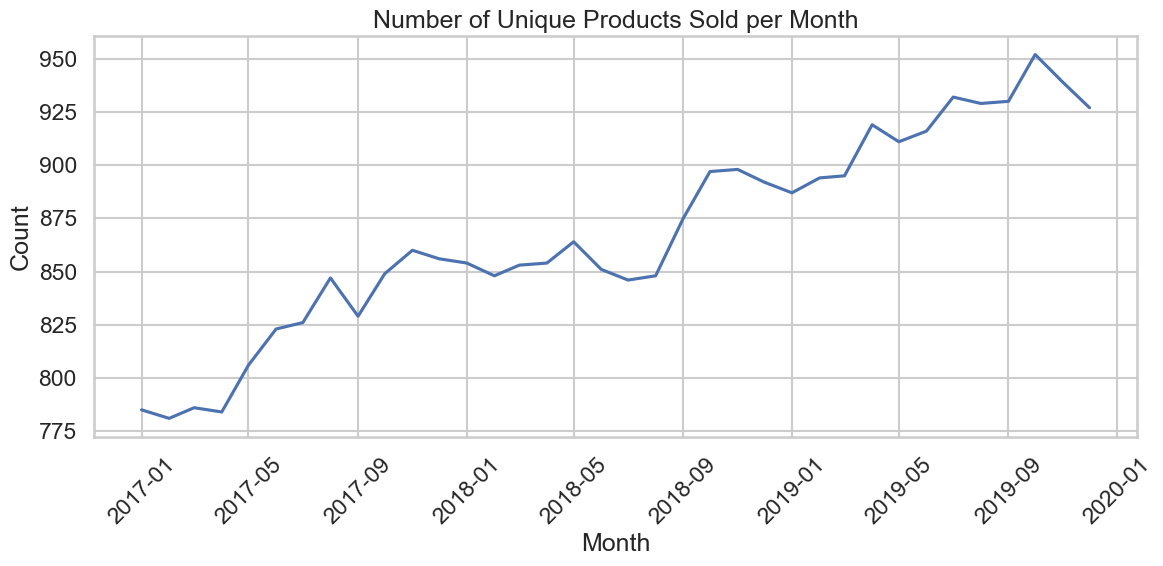

In [11]:
# Number of products sold by month

monthly_product_count = (
    data[data['tn'] > 0]
    .groupby('periodo')['product_id']
    .nunique()
    .reset_index(name='num_products_sold')
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_product_count, x='periodo', y='num_products_sold')
plt.title("Number of Unique Products Sold per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


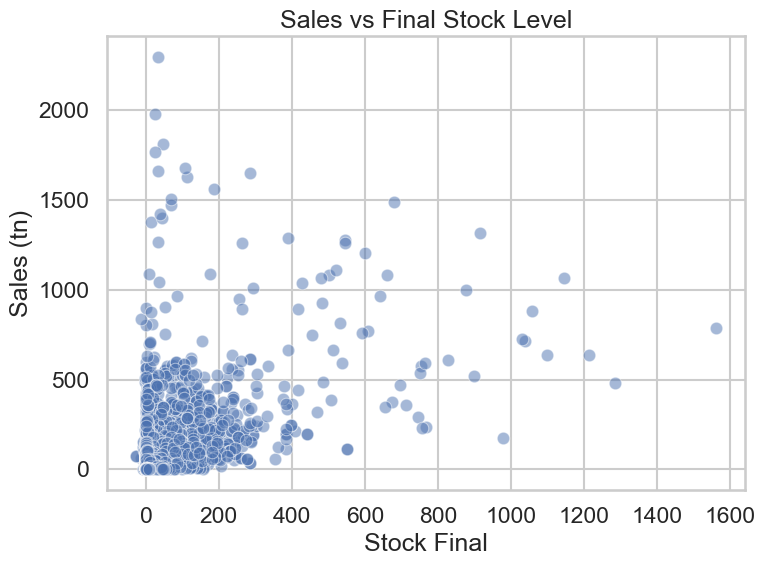

In [12]:
# Stocks vs sales

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='stock_final', y='tn', alpha=0.5)
plt.title("Sales vs Final Stock Level")
plt.xlabel("Stock Final")
plt.ylabel("Sales (tn)")
plt.tight_layout()
plt.show()


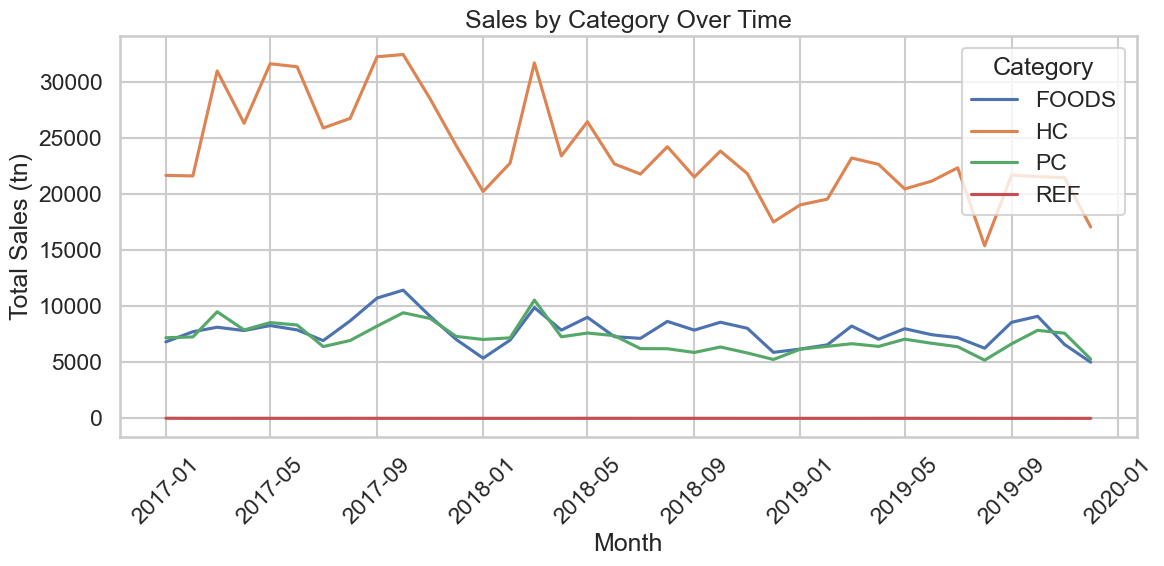

In [13]:
# Category sales over time

cat_monthly = (
    data.groupby(['periodo', 'cat1'])['tn']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=cat_monthly, x='periodo', y='tn', hue='cat1')
plt.title("Sales by Category Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.legend(title="Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


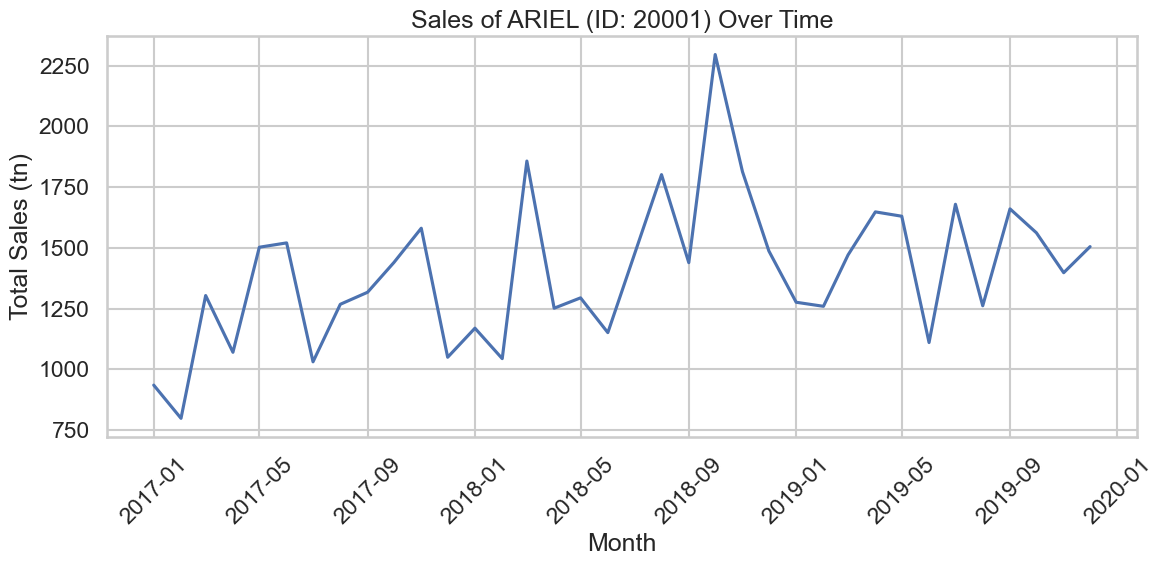

In [14]:
# Filtrar los datos para el producto_id 20001
product_2001 = data[data['product_id'] == 20001]

# Obtener el nombre del producto
product_name = product_info.loc[product_info['product_id'] == 20001, 'brand'].iloc[0]

# Agrupar por periodo y sumar las ventas
product_2001_monthly = (
    product_2001.groupby('periodo')['tn']
    .sum()
    .reset_index()
)

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=product_2001_monthly, x='periodo', y='tn')
plt.title(f"Sales of {product_name} (ID: 20001) Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\s1093678\AppData\Local\Temp\ipykernel_15240\2362886107.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_2001['concentration'] = product_2001.apply(is_concentrated, axis=1)


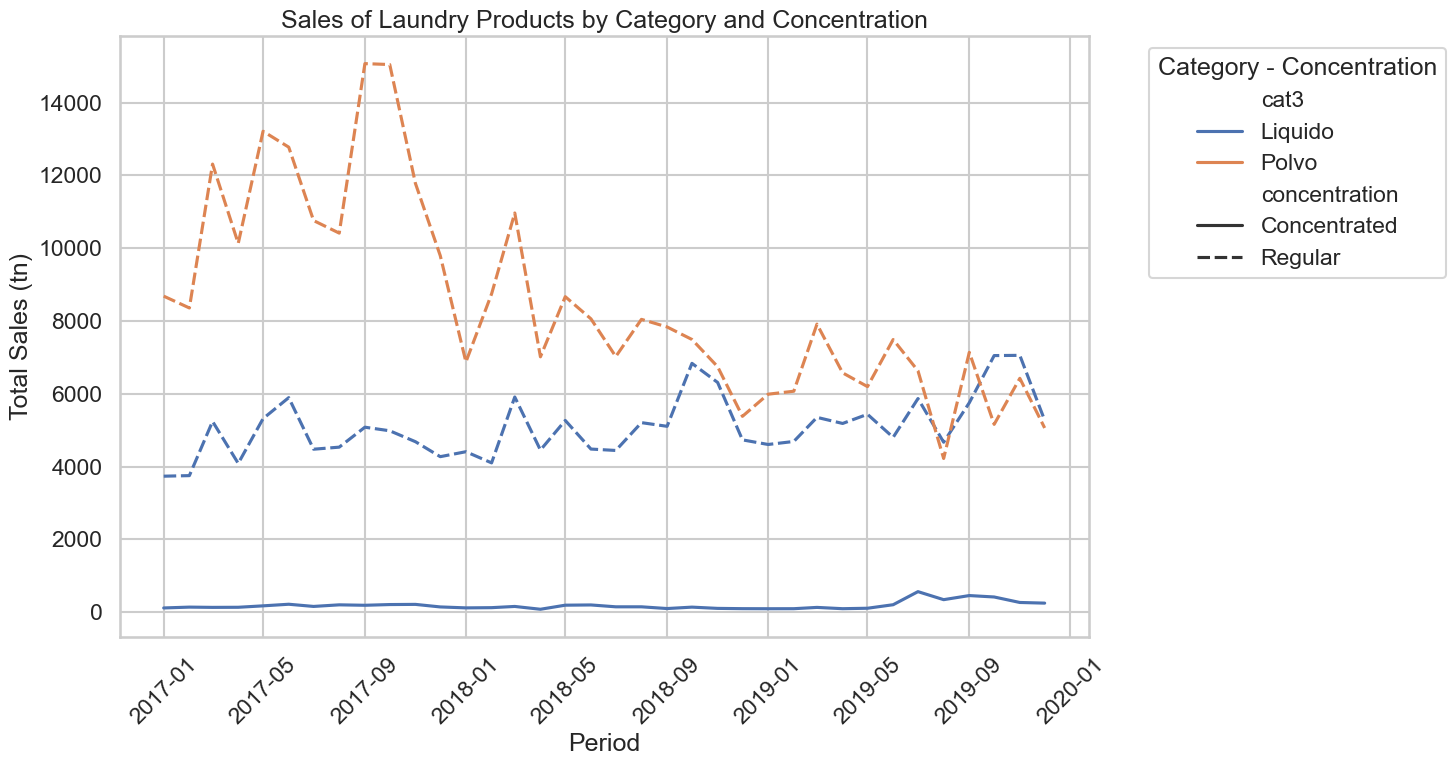

In [15]:
# Filter the data for cat2 == 'ROPA LAVADO'
product_2001 = data[data['cat2'] == 'ROPA LAVADO']

# Create a new category for concentrated products
def is_concentrated(row):
    if row['cat3'] == 'Liquido' and row['sku_size'] <= 500:
        return 'Concentrated'
    else:
        return 'Regular'

product_2001['concentration'] = product_2001.apply(is_concentrated, axis=1)

# Group by periodo, cat3, and concentration, then sum the sales
grouped_data = (
    product_2001.groupby(['periodo', 'cat3', 'concentration'])['tn']
    .sum()
    .reset_index()
)

# Create the plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped_data, x='periodo', y='tn', hue='cat3', style='concentration')

plt.title("Sales of Laundry Products by Category and Concentration")
plt.xlabel("Period")
plt.ylabel("Total Sales (tn)")
plt.legend(title="Category - Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

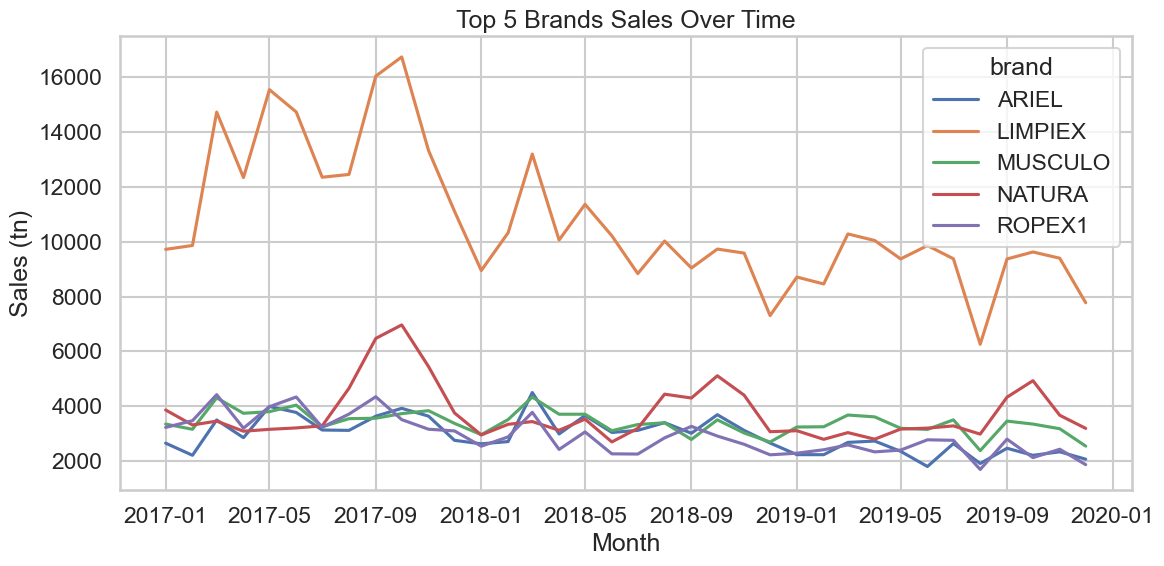

In [16]:
brand_trend = (
    data.groupby(['periodo', 'brand'])['tn']
    .sum()
    .reset_index()
)

top_brands = brand_trend.groupby('brand')['tn'].sum().nlargest(5).index.tolist()
brand_trend_top = brand_trend[brand_trend['brand'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=brand_trend_top, x='periodo', y='tn', hue='brand')
plt.title("Top 5 Brands Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.tight_layout()
plt.show()


In [17]:
# Products that take 90% of sales
# 1. Total sales per product
sales_per_product = data.groupby('product_id')['tn'].sum().reset_index()

# 2. Sort products by sales (descending)
sales_per_product = sales_per_product.sort_values(by='tn', ascending=False).reset_index(drop=True)

# 3. Calculate cumulative sales
sales_per_product['cumulative_tn'] = sales_per_product['tn'].cumsum()
total_sales = sales_per_product['tn'].sum()
sales_per_product['cumulative_pct'] = sales_per_product['cumulative_tn'] / total_sales

# 4. Find products that make up 90% of sales
top_90_products = sales_per_product[sales_per_product['cumulative_pct'] <= 0.9]


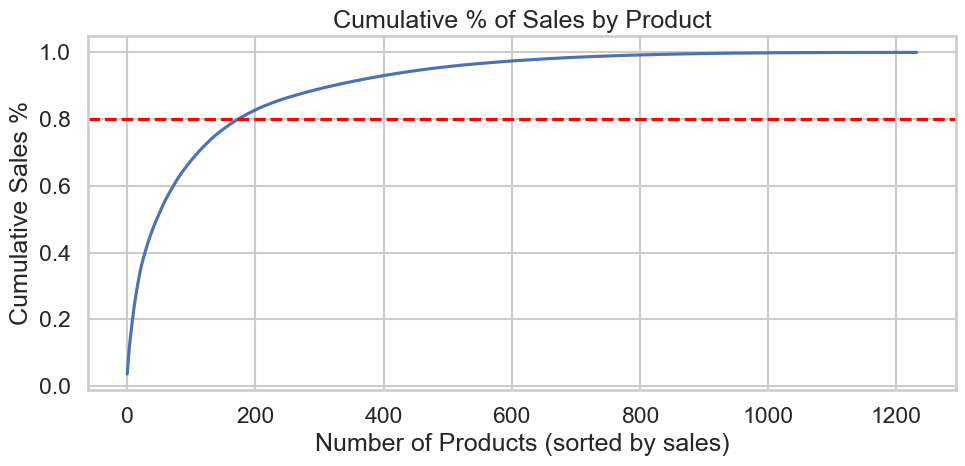

In [18]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_per_product, x=range(len(sales_per_product)), y='cumulative_pct')
plt.axhline(0.8, color='red', linestyle='--')
plt.title("Cumulative % of Sales by Product")
plt.xlabel("Number of Products (sorted by sales)")
plt.ylabel("Cumulative Sales %")
plt.tight_layout()
plt.show()


In [19]:
print(f"Total number of products: {len(sales_per_product)}")
print(f"Number of products that account for 90% of sales: {len(top_90_products)}")
print("\nTop products by total tn:")
print(top_90_products.head(10))


Total number of products: 1233
Number of products that account for 90% of sales: 321

Top products by total tn:
   product_id           tn  cumulative_tn  cumulative_pct
0       20001  50340.39558    50340.39558        0.036081
1       20010  37342.15836    87682.55394        0.062845
2       20002  36337.25439   124019.80833        0.088889
3       20003  32004.15274   156023.96107        0.111827
4       20021  25003.78252   181027.74359        0.129748
5       20020  24516.78008   205544.52367        0.147320
6       20004  24178.15379   229722.67746        0.164649
7       20005  23191.21852   252913.89598        0.181271
8       20007  22018.45234   274932.34832        0.197053
9       20022  21387.99848   296320.34680        0.212382


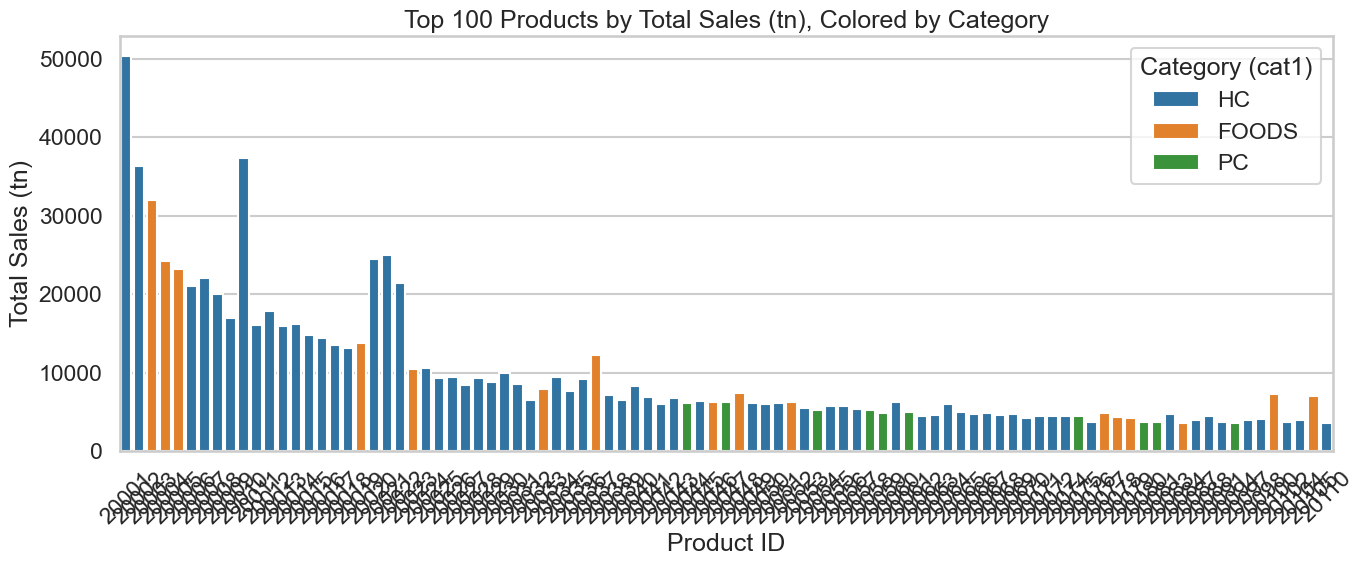

In [20]:
# Merge to add category (cat1) to top 90% products
top_90_merged = top_90_products.merge(product_info[['product_id', 'cat1']], on='product_id', how='left')

# Take the top 20 products by total sales
top_100 = top_90_merged.head(100)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=top_100,
    x='product_id',
    y='tn',
    hue='cat1',
    dodge=False,
    palette='tab10'
)

plt.title("Top 100 Products by Total Sales (tn), Colored by Category")
plt.xlabel("Product ID")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.legend(title="Category (cat1)")
plt.tight_layout()
plt.show()


C:\Users\s1093678\AppData\Local\Temp\ipykernel_15240\4190855226.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat2_sales, x='cat2', y='tn', palette='tab10')


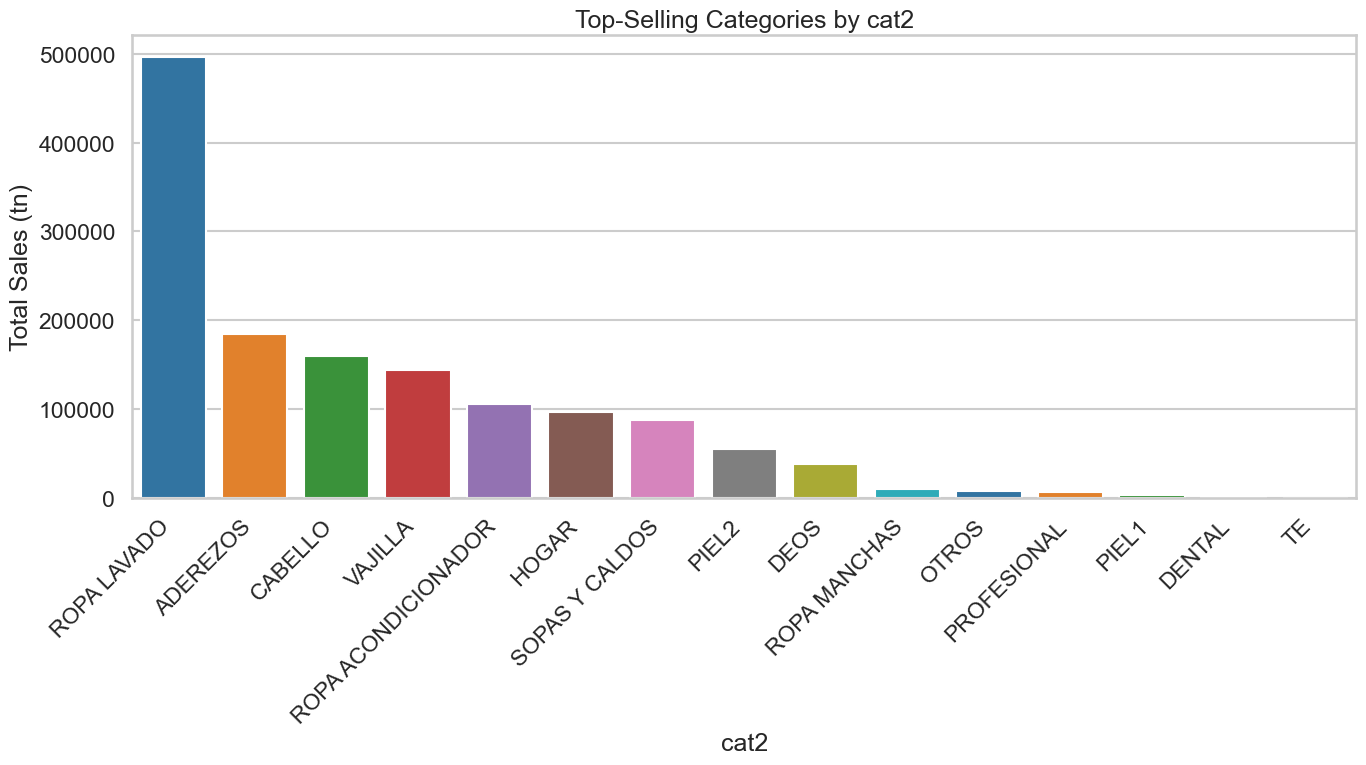

In [21]:
# Step 1: Merge sales with product_info to get cat2
data_with_cat2 = data.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Step 2: Group by cat2 and sum total sales
cat2_sales = (
    data.groupby('cat2')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Step 3: Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=cat2_sales, x='cat2', y='tn', palette='tab10')
plt.title("Top-Selling Categories by cat2")
plt.xlabel("cat2")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

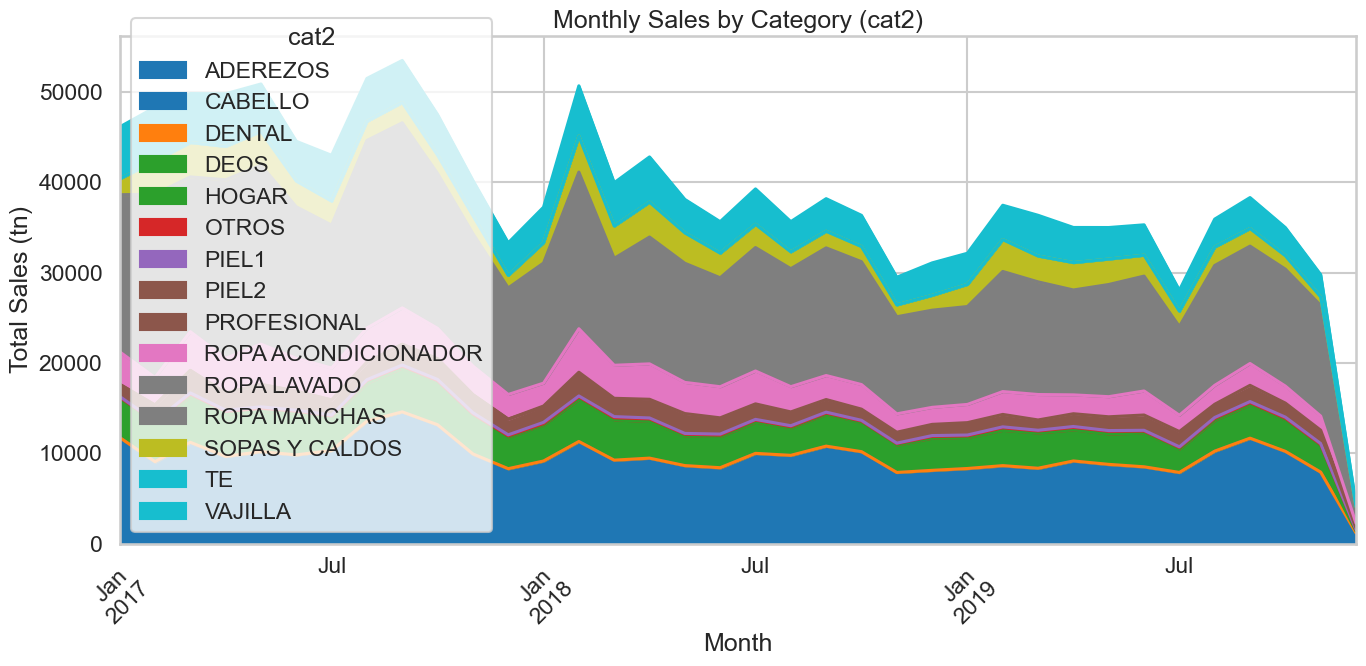

In [22]:
#Mismo grfico pero de lineas
# Step 1: Merge data with cat2
data_with_cat2 = data.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Step 2: Aggregate monthly sales by cat2
monthly_cat2 = (
    data.groupby([data_with_cat2['periodo'], 'cat2'])['tn']
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

# Step 3: Plot stacked area chart
plt.figure(figsize=(14, 7))
monthly_cat2.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab10')
plt.title("Monthly Sales by Category (cat2)")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


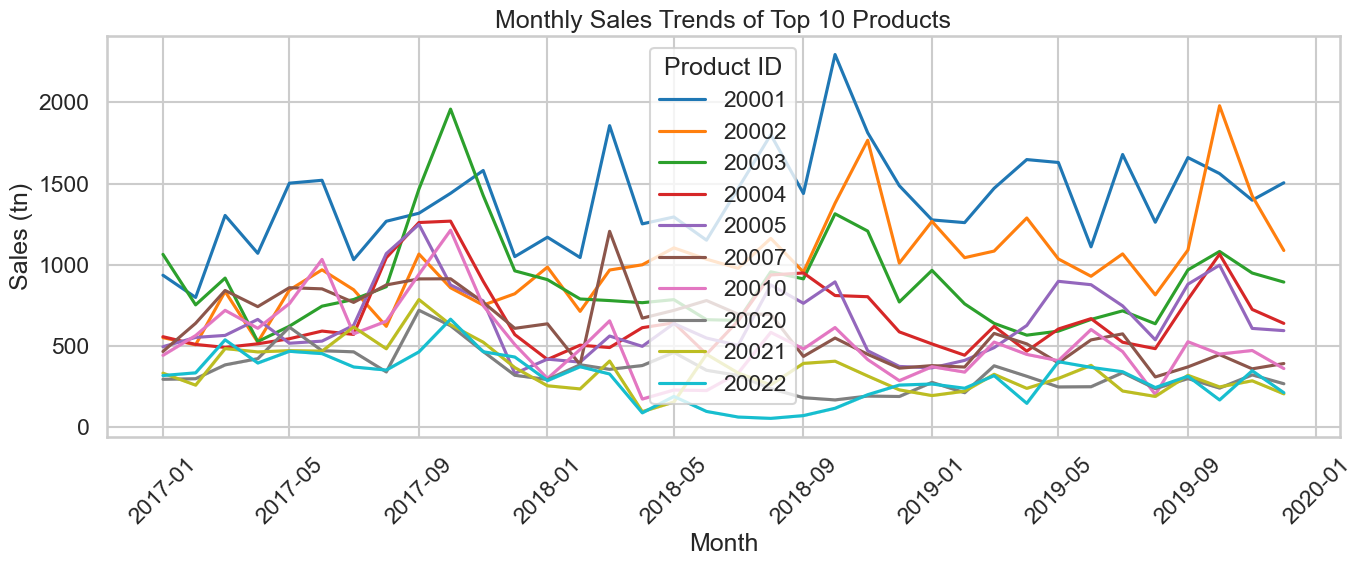

In [23]:
#Top 20 products trends over time

top_n = 10
top_product_ids = (
    data.groupby('product_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
)

top_product_trend = data[data['product_id'].isin(top_product_ids)]

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=top_product_trend,
    x='periodo',
    y='tn',
    hue='product_id',
    palette='tab10'
)
plt.title(f"Monthly Sales Trends of Top {top_n} Products")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.xticks(rotation=45)
plt.legend(title="Product ID")
plt.tight_layout()
plt.show()



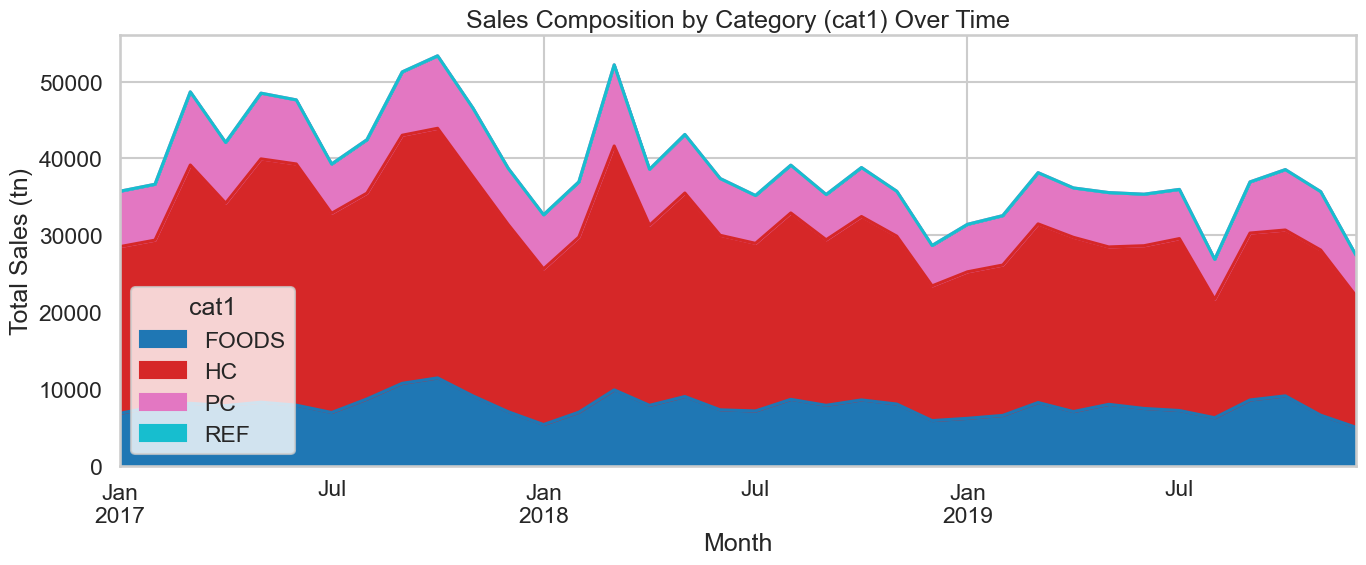

In [24]:
# Category composition over time

# Aggregate by period and cat1
cat_time = data.groupby(['periodo', 'cat1'])['tn'].sum().unstack().fillna(0)

# Plot as stacked area
cat_time.plot(kind='area', stacked=True, figsize=(14, 6), colormap='tab10')
plt.title("Sales Composition by Category (cat1) Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales (tn)")
plt.tight_layout()
plt.show()


In [25]:
# Productos con high sales pero low stocks

stockouts = data[(data['stock_final'] < 0.1) & (data['tn'] > 0)]

print("Number of stockout events:", len(stockouts))
print(stockouts[['periodo', 'product_id', 'stock_final', 'tn']].head(10))


Number of stockout events: 1550
         periodo  product_id  stock_final         tn
26132 2018-10-01       20009      0.05580  596.92913
26189 2018-10-01       20063      0.02877  188.75855
26191 2018-10-01       20065      0.02457  177.73938
26216 2018-10-01       20092      0.04095   90.55683
26219 2018-10-01       20095     -0.02730   98.29376
26221 2018-10-01       20097      0.05576   74.65509
26276 2018-10-01       20160      0.02798   48.60553
26287 2018-10-01       20175      0.00000   45.43899
26288 2018-10-01       20176      0.00000   28.11723
26290 2018-10-01       20178     -0.02974   42.98745


C:\Users\s1093678\AppData\Local\Temp\ipykernel_15240\3637450565.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=brand_total_sales.head(20), x='brand', y='tn', palette='tab10')


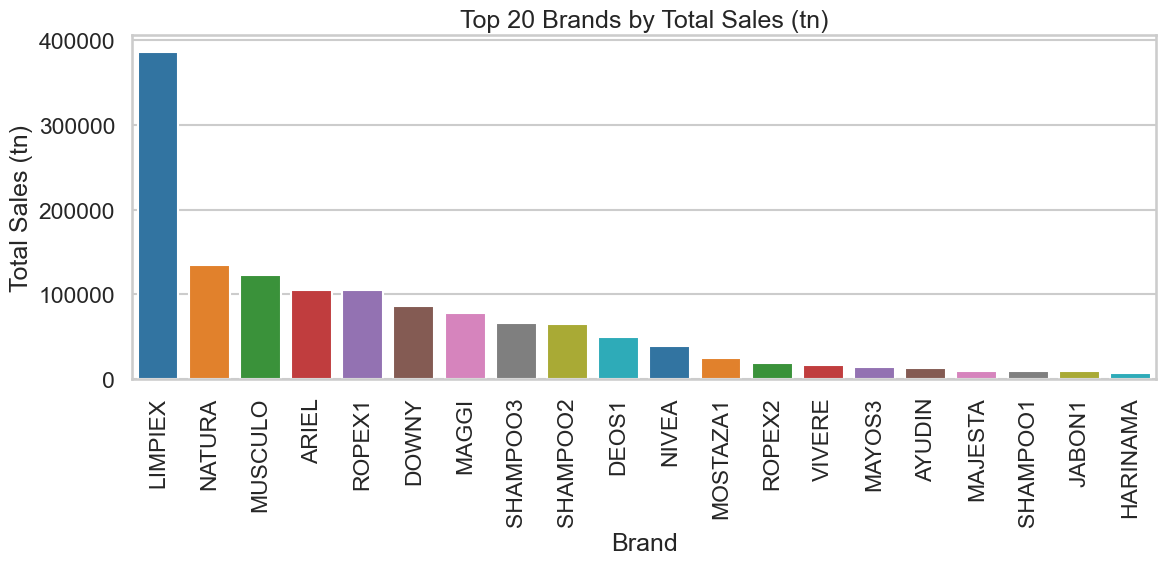

In [26]:
# Top brands for total sales

brand_total_sales = (
    data.groupby('brand')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(data=brand_total_sales.head(20), x='brand', y='tn', palette='tab10')
plt.title("Top 20 Brands by Total Sales (tn)")
plt.xlabel("Brand")
plt.ylabel("Total Sales (tn)")
plt.xticks(rotation=90)  # Rotate labels vertically
plt.tight_layout()
plt.show()


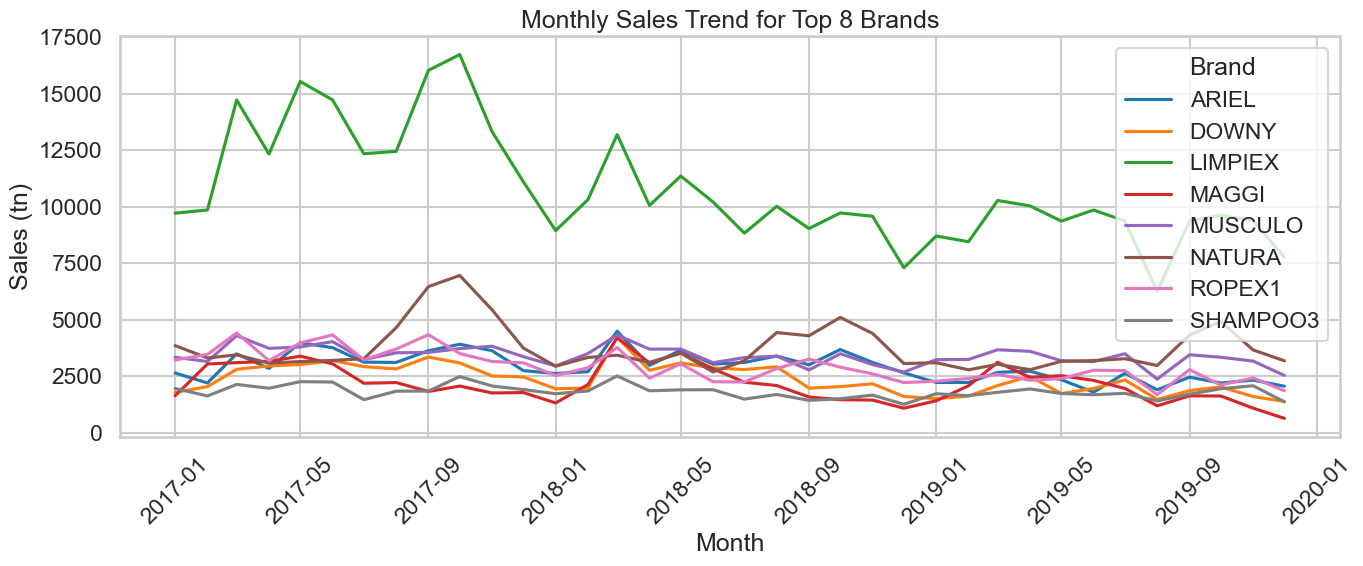

In [27]:
#Monthly sales for top brands

top_n = 8
top_brand_list = brand_total_sales['brand'].head(top_n).tolist()

brand_monthly = (
    data[data['brand'].isin(top_brand_list)]
    .groupby(['periodo', 'brand'])['tn']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=brand_monthly, x='periodo', y='tn', hue='brand', palette='tab10')
plt.title(f"Monthly Sales Trend for Top {top_n} Brands")
plt.xlabel("Month")
plt.ylabel("Sales (tn)")
plt.legend(title="Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# Sales decline/increase rate by brand

brand_time = (
    data.groupby(['periodo', 'brand'])['tn']
    .sum()
    .reset_index()
)

brand_first_last = (
    brand_time.groupby('brand')
    .agg(first=('tn', 'first'), last=('tn', 'last'))
    .assign(pct_change=lambda df: (df['last'] - df['first']) / df['first'])
    .sort_values(by='pct_change', ascending=False)
)

print("Top growing brands:")
print(brand_first_last.head(5))

print("\nTop declining brands:")
print(brand_first_last.tail(5))



Top growing brands:
            first       last  pct_change
brand                                   
SALSATI       0.0  102.84561         inf
VICHY         0.0    0.10585         inf
OFF           0.0    5.06529         inf
INDUSTRIAL    0.0   10.95831         inf
FRANCIA       0.0    9.99344         inf

Top declining brands:
               first       last  pct_change
brand                                      
MAGGI     1650.68107  649.83663   -0.606322
ESPADOL     48.40814   15.64821   -0.676744
DEOS3       80.94587   23.37533   -0.711223
TWININGS     8.98416    0.36893   -0.958936
JABON1     305.84438    4.37389   -0.985699


In [29]:
#Products with mostly zero sales
sales_zero_ratio = (
    data.groupby('product_id')['tn']
    .apply(lambda x: (x == 0).sum() / len(x))
    .reset_index(name='pct_zero_sales')
    .sort_values(by='pct_zero_sales', ascending=False)
)

print("Products with highest percentage of zero-sales months:")
print(sales_zero_ratio.head(10))



Products with highest percentage of zero-sales months:
      product_id  pct_zero_sales
1232       21299        0.972222
1204       21270        0.972222
1209       21275        0.972222
1120       21169        0.972222
1230       21297        0.972222
1229       21296        0.972222
1228       21295        0.972222
1218       21285        0.972222
1222       21289        0.972222
1225       21292        0.972222


Products with most frequent stockouts:
      product_id  pct_stockout_months
1132       21184             0.333333
1146       21201             0.250000
1155       21212             0.250000
1198       21264             0.222222
51         20052             0.194444
320        20323             0.194444
1076       21113             0.194444
266        20268             0.166667
267        20269             0.166667
236        20238             0.166667


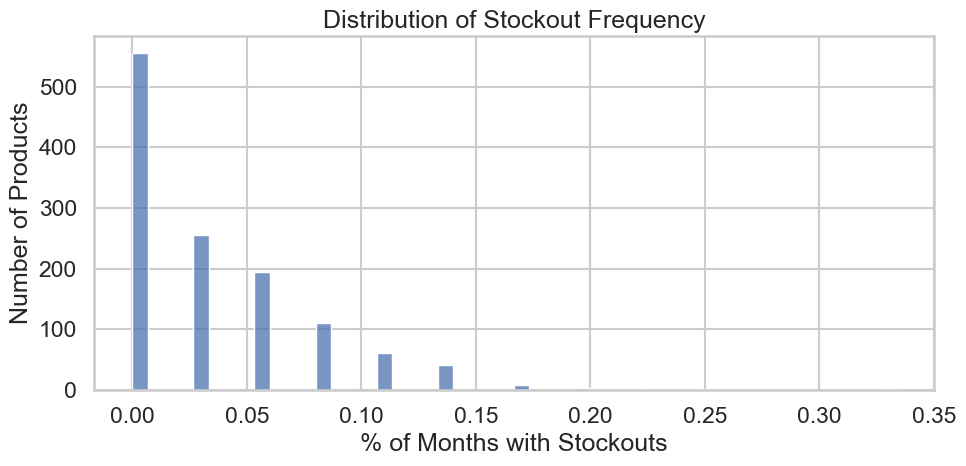

In [30]:
#Stockout frequency table

data['stockout'] = data['stock_final'] < 0.1

stockout_summary = (
    data.groupby('product_id')['stockout']
    .mean()
    .reset_index()
    .rename(columns={'stockout': 'pct_stockout_months'})
    .sort_values(by='pct_stockout_months', ascending=False)
)

print("Products with most frequent stockouts:")
print(stockout_summary.head(10))

plt.figure(figsize=(10, 5))
sns.histplot(stockout_summary['pct_stockout_months'], bins=50)
plt.title("Distribution of Stockout Frequency")
plt.xlabel("% of Months with Stockouts")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()

In [31]:
#Sales volatility per product

volatility = (
    data.groupby('product_id')['tn']
    .agg(['mean', 'std'])
    .reset_index()
)
volatility['coeff_var'] = volatility['std'] / volatility['mean']

volatility = volatility.sort_values(by='coeff_var', ascending=False)
print("Most volatile products (coefficient of variation):")
print(volatility[['product_id', 'coeff_var']].head(10))


Most volatile products (coefficient of variation):
      product_id  coeff_var
1229       21296        6.0
1231       21298        6.0
1120       21169        6.0
1228       21295        6.0
1222       21289        6.0
1218       21285        6.0
842        20854        6.0
782        20792        6.0
760        20770        6.0
1204       21270        6.0


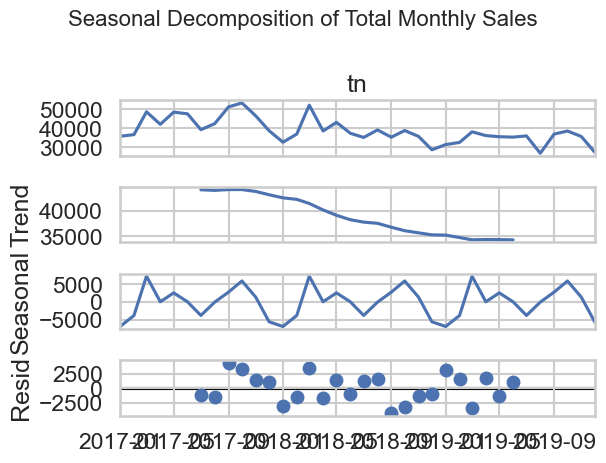

In [32]:
#Decomposition of total sales over time
# Decompose the time series to analyze trend, seasonality, and residuals

from statsmodels.tsa.seasonal import seasonal_decompose

monthly_total = monthly_total.set_index('periodo')
monthly_total = monthly_total.asfreq('MS')  # ensure monthly frequency

decomp = seasonal_decompose(monthly_total['tn'], model='additive', period=12)

decomp.plot()
plt.suptitle("Seasonal Decomposition of Total Monthly Sales", fontsize=16)
plt.tight_layout()
plt.show()


In [39]:
data['month'] = data['periodo'].dt.month

In [40]:
#Most seasonal products

product_monthly = data.groupby(['product_id', 'month'])['tn'].mean().unstack()

# Calculate standard deviation across months
seasonality_strength = product_monthly.std(axis=1).sort_values(ascending=False)

top_seasonal_products = seasonality_strength.head(10)

print("Top 10 most seasonal products (high monthly variation):")
print(top_seasonal_products)


Top 10 most seasonal products (high monthly variation):
product_id
20003    250.953674
20001    200.681024
20004    196.414002
20005    180.412603
20002    179.455758
20010    121.268895
20007    120.438023
20019    117.650719
20006     98.610994
20012     94.650701
dtype: float64


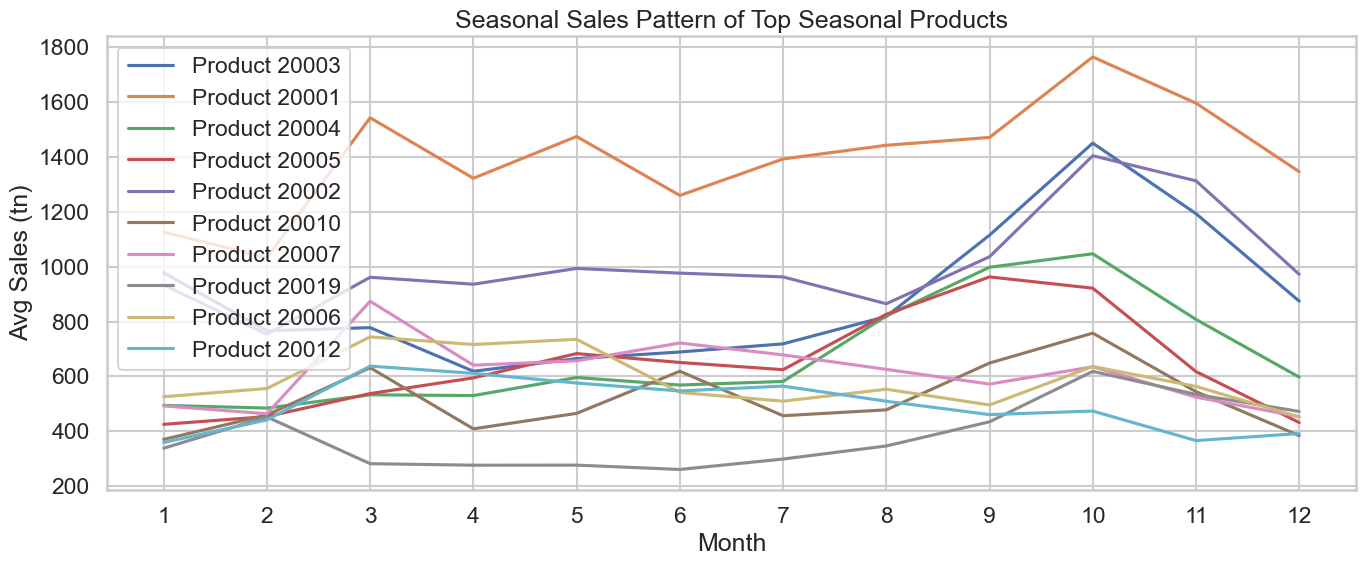

In [41]:
# Plotting a few of the most seasonal products
top_ids = top_seasonal_products.index[:10]

plt.figure(figsize=(14, 6))  # Wider figure

for pid in top_ids:
    plt.plot(product_monthly.columns, product_monthly.loc[pid], label=f'Product {pid}')

plt.title("Seasonal Sales Pattern of Top Seasonal Products")
plt.xlabel("Month")
plt.ylabel("Avg Sales (tn)")
plt.xticks(product_monthly.columns)  # Ensure months are labeled
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\s1093678\AppData\Local\Temp\ipykernel_15240\2125222133.py:13: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(product_monthly.columns, product_monthly.loc[pid], label=label)


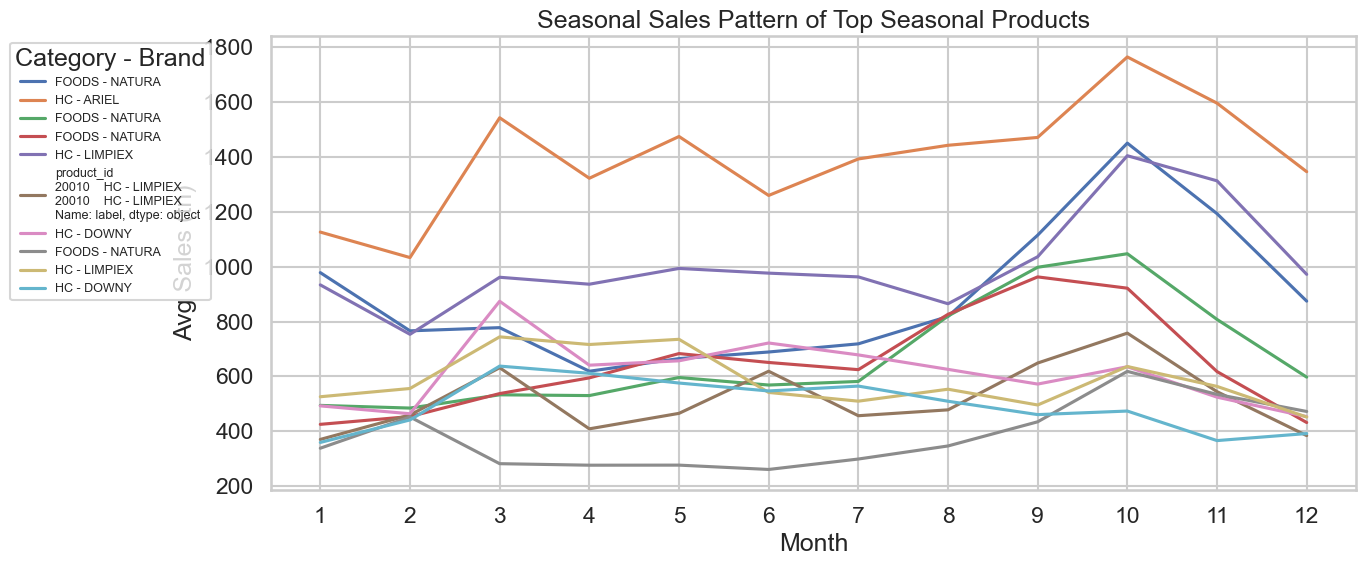

In [42]:
# Step 1: Get top seasonal product IDs
top_ids = top_seasonal_products.index[:10]

# Step 2: Merge with product_info to get labels
label_lookup = product_info.set_index('product_id').loc[top_ids][['cat1', 'brand']]
label_lookup['label'] = label_lookup['cat1'] + ' - ' + label_lookup['brand']

# Step 3: Plot with labeled lines
plt.figure(figsize=(14, 6))

for pid in top_ids:
    label = label_lookup.loc[pid, 'label']
    plt.plot(product_monthly.columns, product_monthly.loc[pid], label=label)

plt.title("Seasonal Sales Pattern of Top Seasonal Products")
plt.xlabel("Month")
plt.ylabel("Avg Sales (tn)")
plt.xticks(product_monthly.columns)

# Place the legend to the left, with smaller font
plt.legend(
    title="Category - Brand",
    prop={'size': 9},
    bbox_to_anchor=(-0.05, 1),  # move legend left of plot
    loc='upper right'
)

plt.tight_layout()
plt.show()


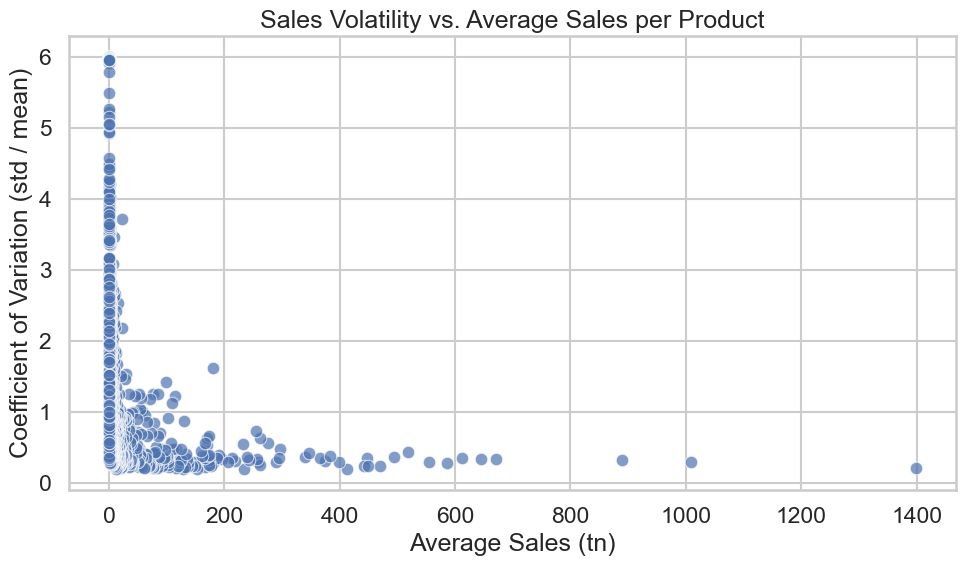

In [43]:
#Volatility vs sales

volatility_df = data.groupby('product_id')['tn'].agg(['mean', 'std']).reset_index()
volatility_df['cv'] = volatility_df['std'] / (volatility_df['mean'] + 1e-6)  # avoid division by zero

plt.figure(figsize=(10, 6))
sns.scatterplot(data=volatility_df, x='mean', y='cv', alpha=0.7)
plt.title("Sales Volatility vs. Average Sales per Product")
plt.xlabel("Average Sales (tn)")
plt.ylabel("Coefficient of Variation (std / mean)")
plt.tight_layout()
plt.show()


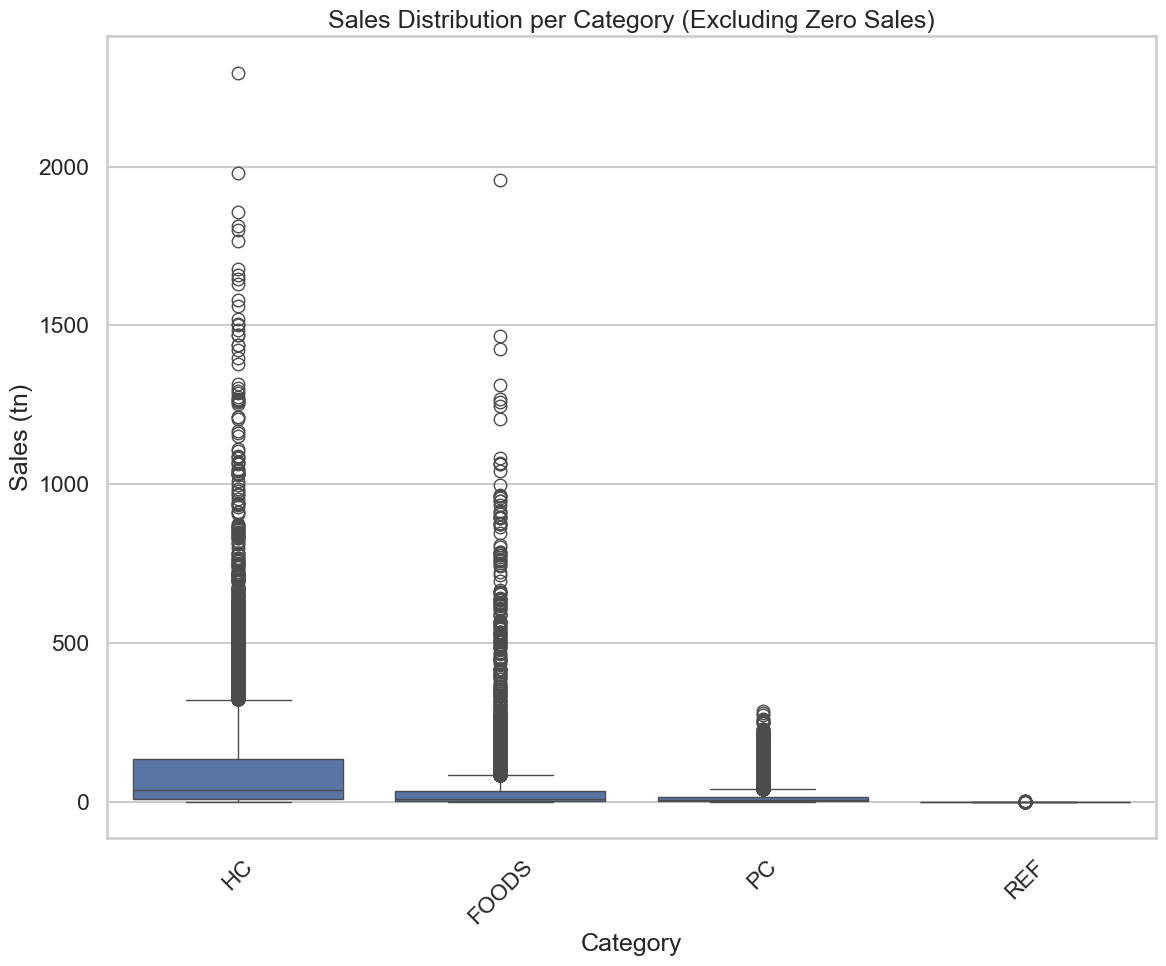

In [44]:
#Sales per category (boxplot)

plt.figure(figsize=(12, 10))
sns.boxplot(data=data[data['tn'] > 0], x='cat1', y='tn')
plt.title("Sales Distribution per Category (Excluding Zero Sales)")
plt.xlabel("Category")
plt.ylabel("Sales (tn)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


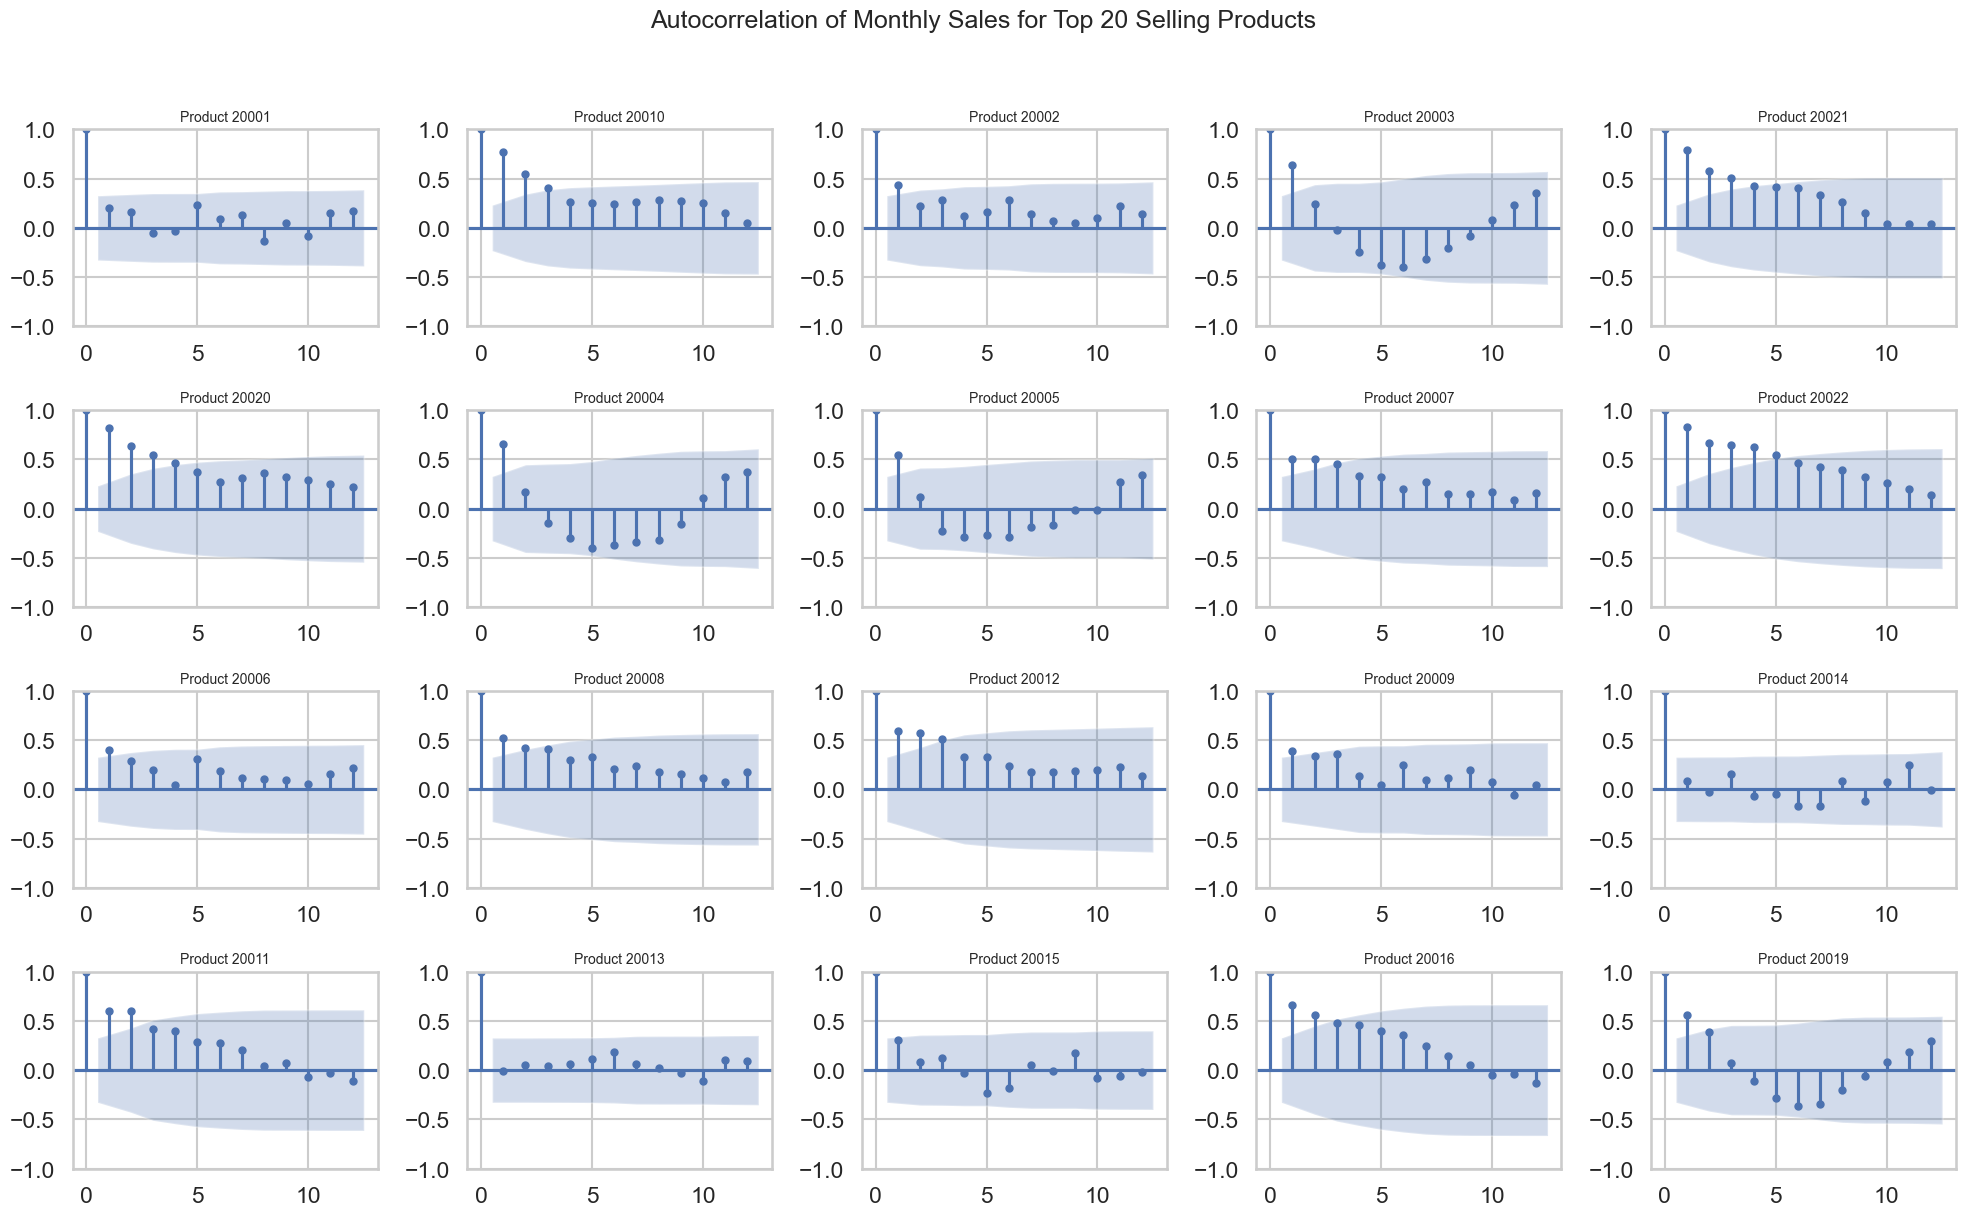

In [45]:
#Autocorrelation for top selling products

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

top_n = 20
top_products = data.groupby('product_id')['tn'].sum().nlargest(top_n).index.tolist()

# Set up 4 rows × 5 columns
nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
axes = axes.flatten()

for i, pid in enumerate(top_products):
    sales_series = (
        data[data['product_id'] == pid]
        .sort_values('periodo')['tn']
        .reset_index(drop=True)
    )
    
    plot_acf(sales_series, lags=12, ax=axes[i])
    axes[i].set_title(f'Product {pid}', fontsize=10)

# Turn off unused axes (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Autocorrelation of Monthly Sales for Top 20 Selling Products", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()


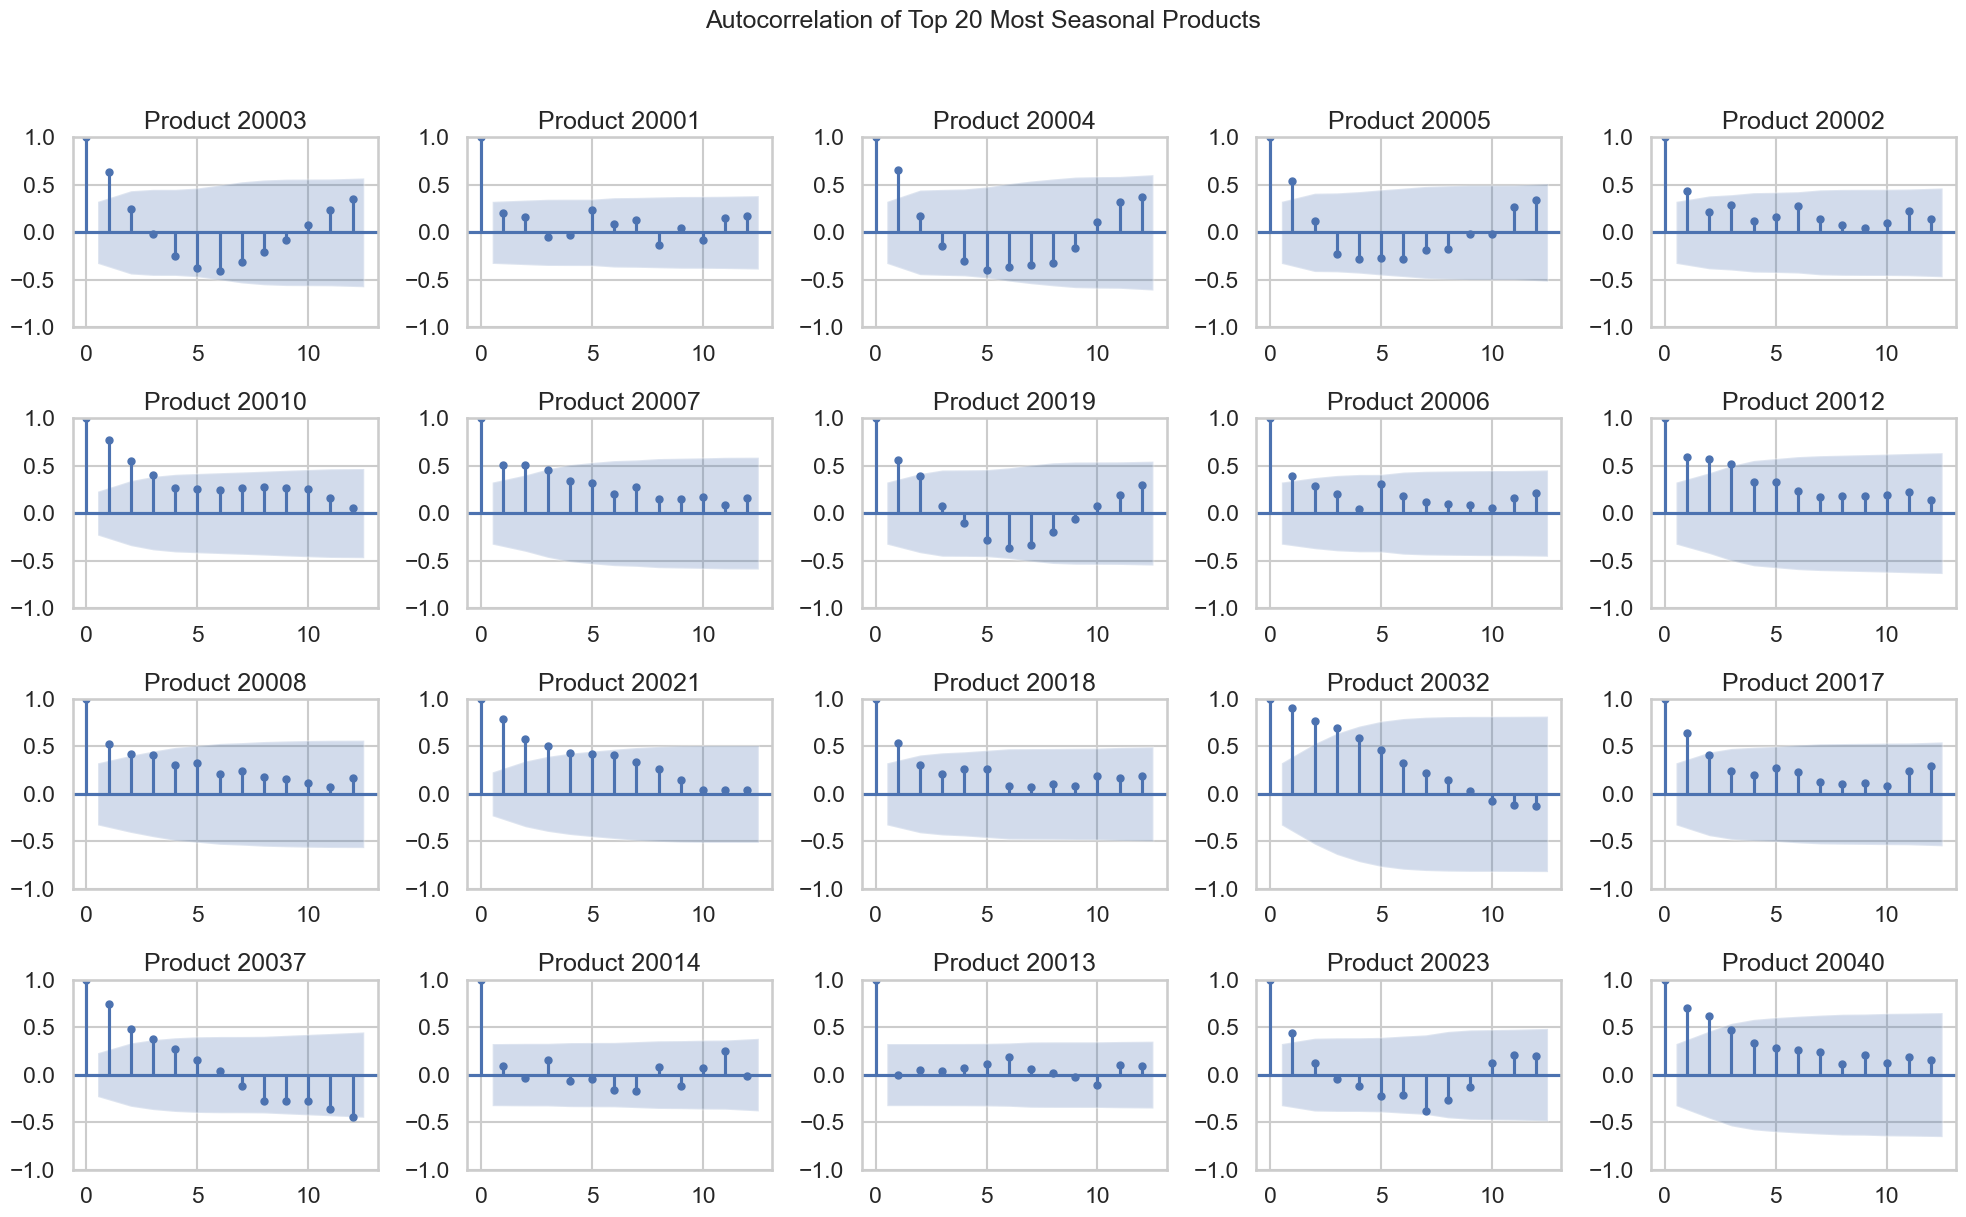

In [46]:
#Autocorrelation for most seasonal products
product_monthly = data.groupby(['product_id', 'month'])['tn'].mean().unstack(fill_value=0)
seasonality_strength = product_monthly.std(axis=1).sort_values(ascending=False)
top_20_seasonal_ids = seasonality_strength.head(20).index.tolist()

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Set up 4 rows × 5 columns for 20 plots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
axes = axes.flatten()  # flatten 2D array of axes for easy indexing

# Loop through top 20 products
for i, pid in enumerate(top_20_seasonal_ids):
    sales_series = (
        data[data['product_id'] == pid]
        .sort_values('periodo')['tn']
        .reset_index(drop=True)
    )

    plot_acf(sales_series, lags=12, ax=axes[i])
    axes[i].set_title(f'Product {pid}')

# Turn off any unused subplots (if less than 20)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Autocorrelation of Top 20 Most Seasonal Products", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()


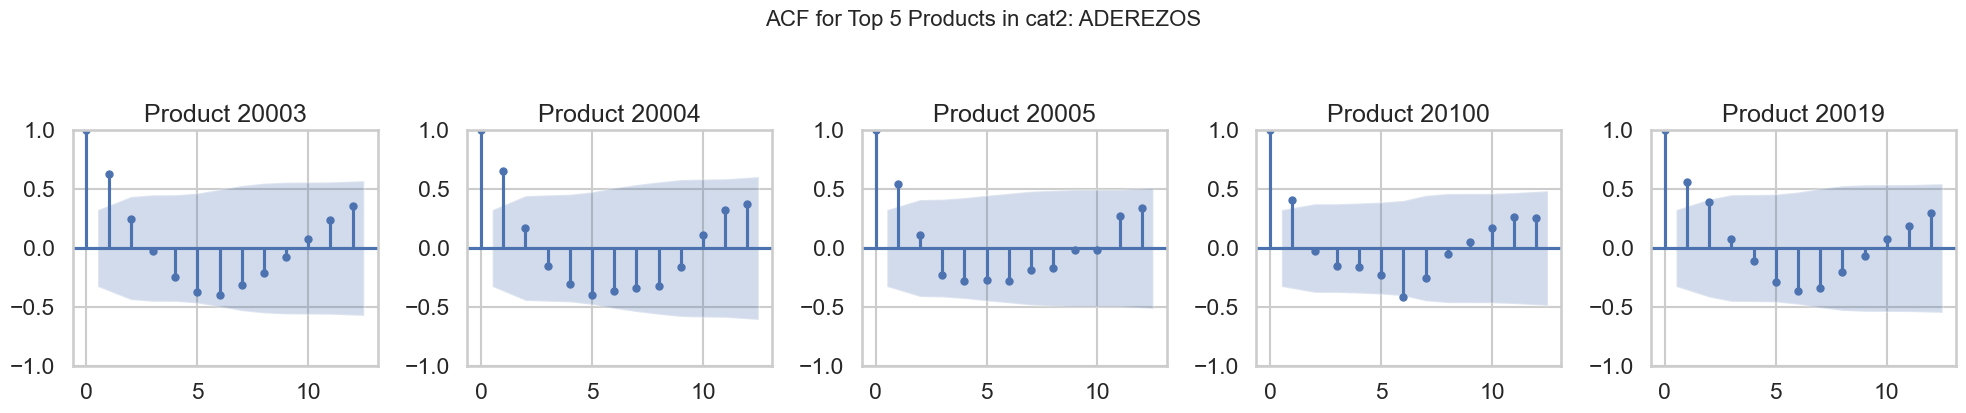

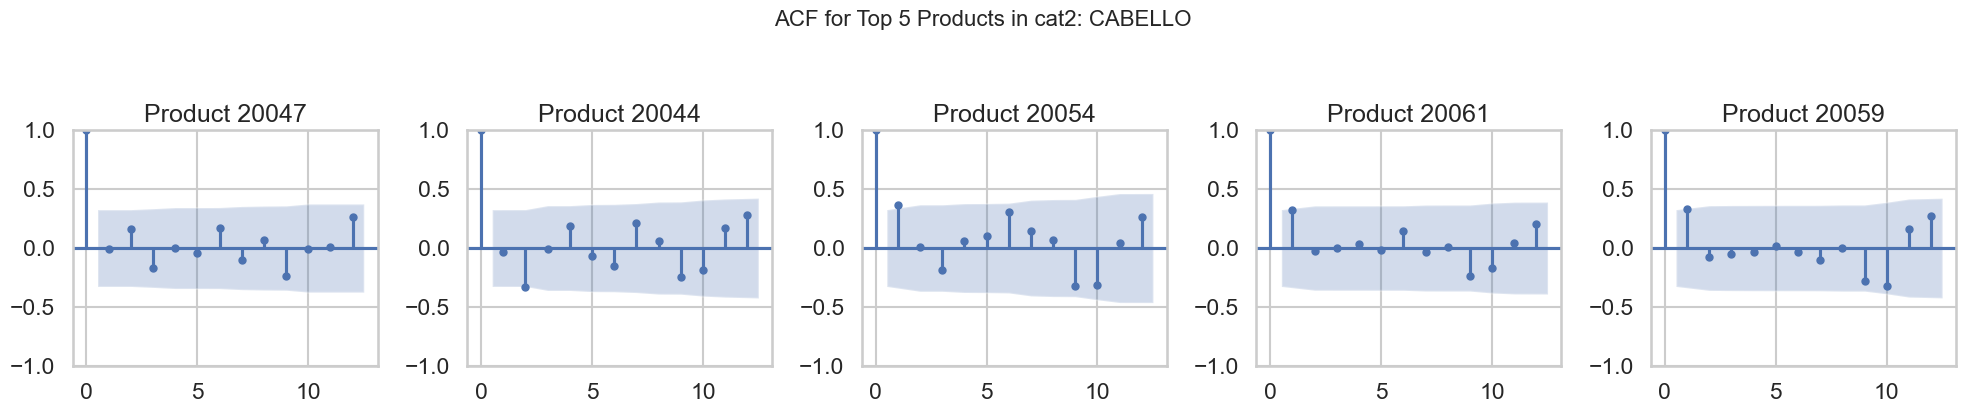

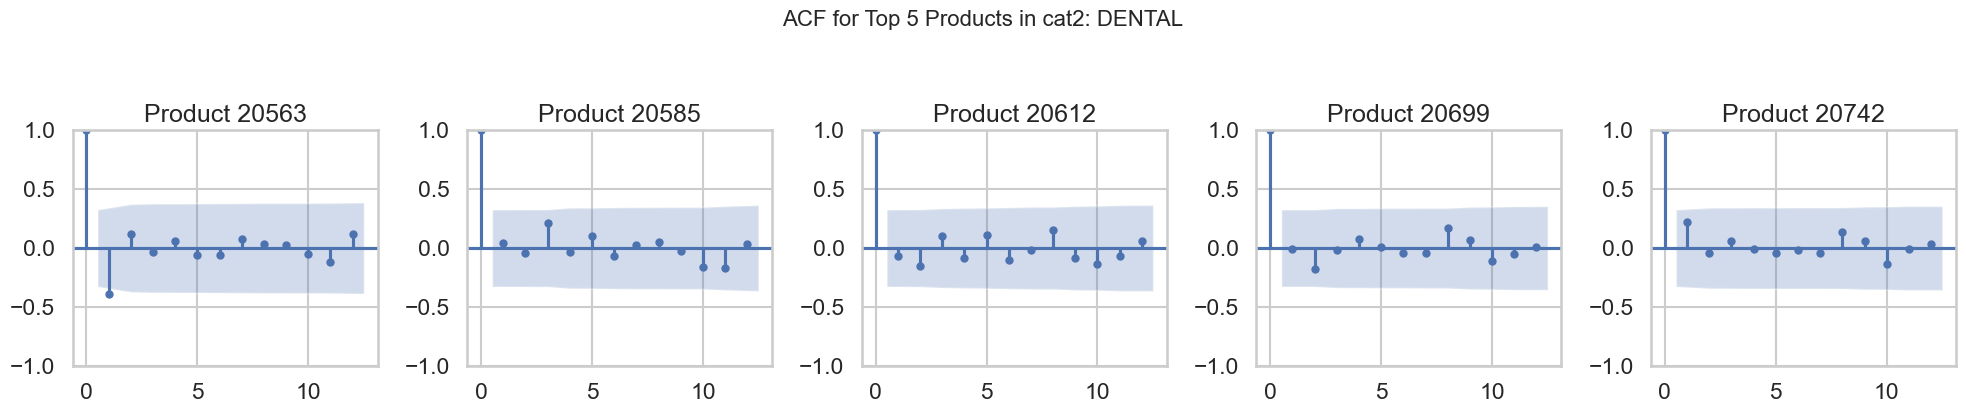

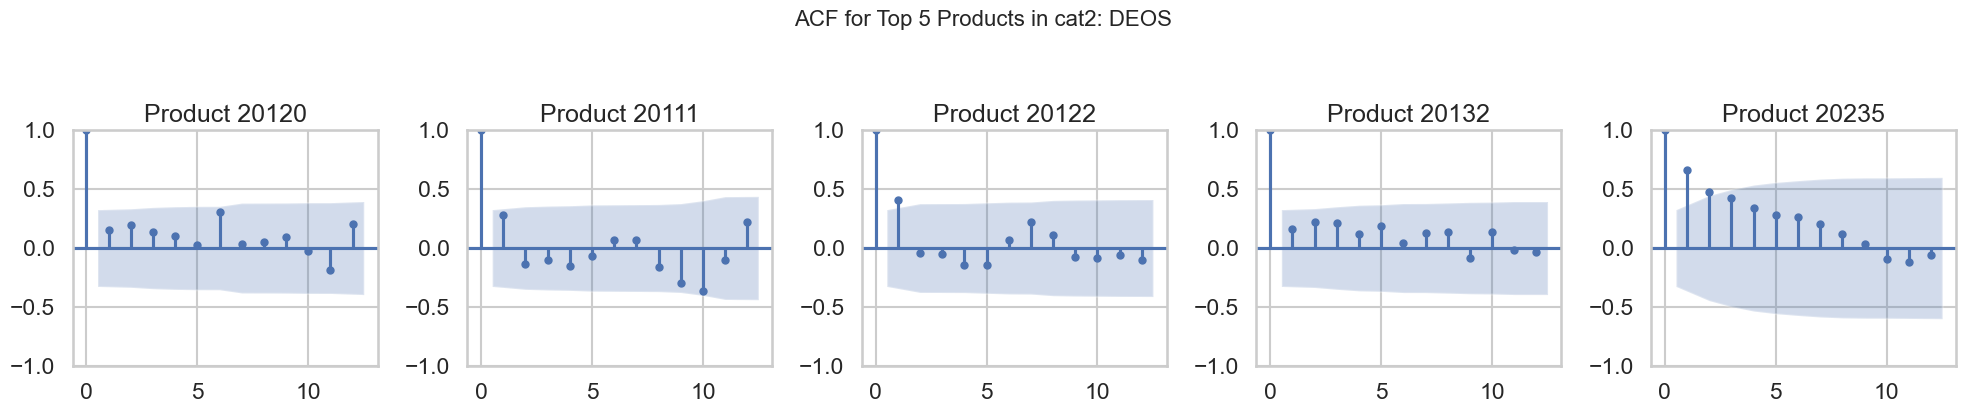

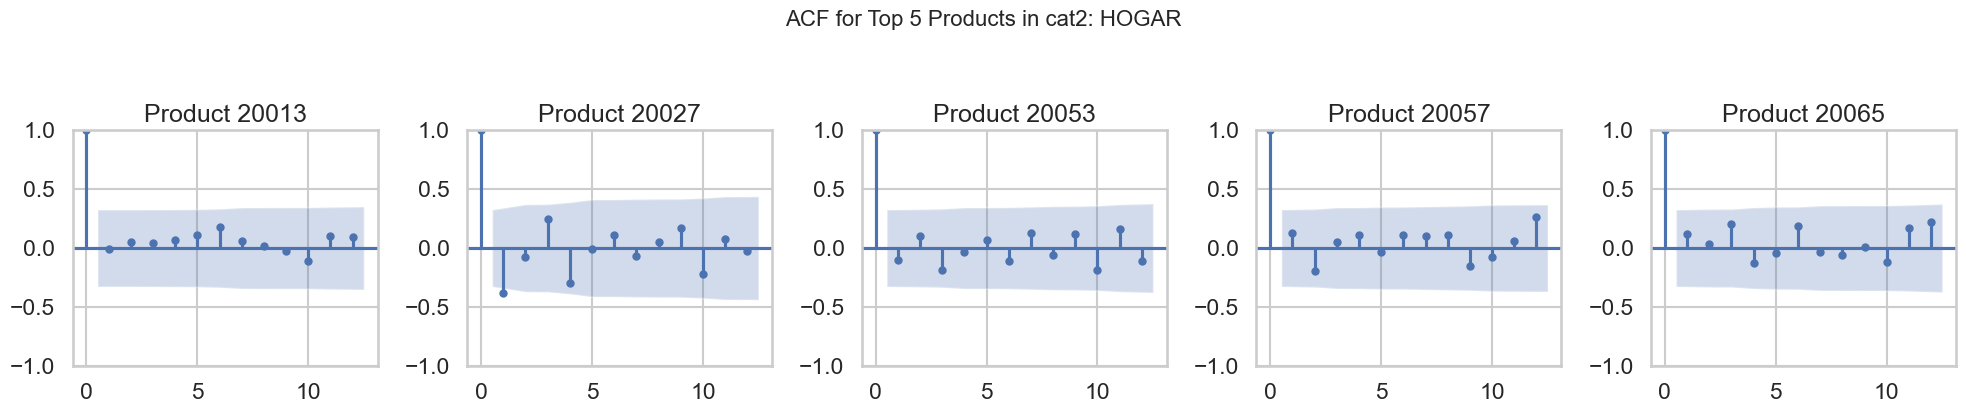

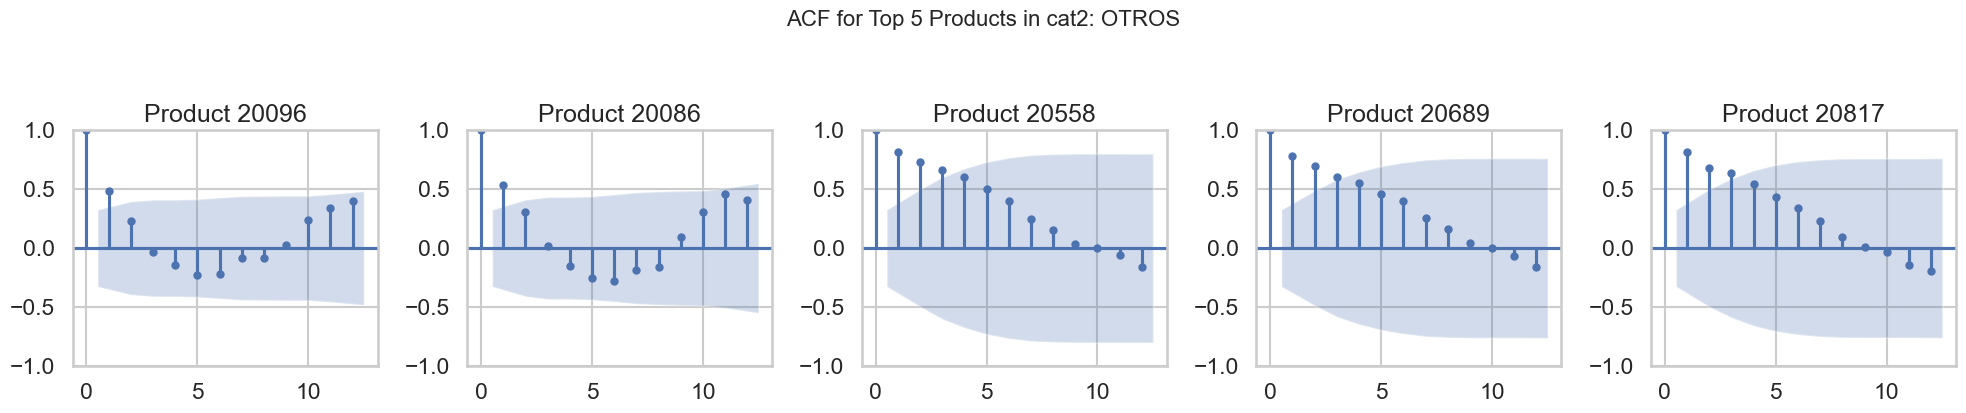

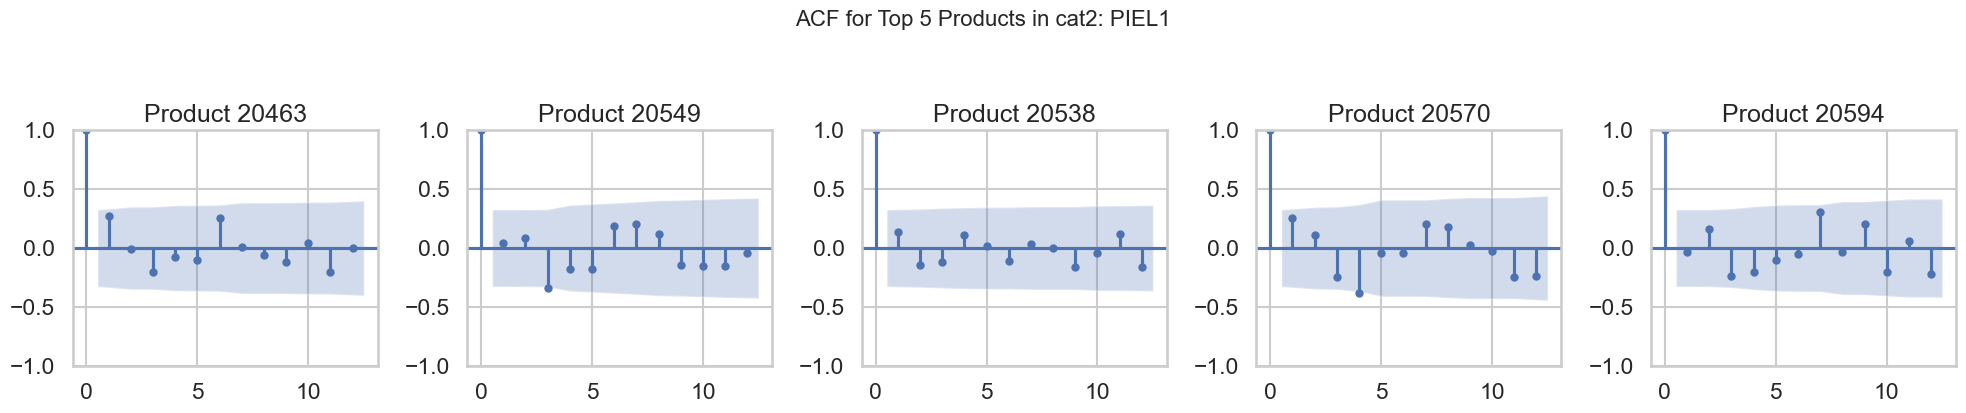

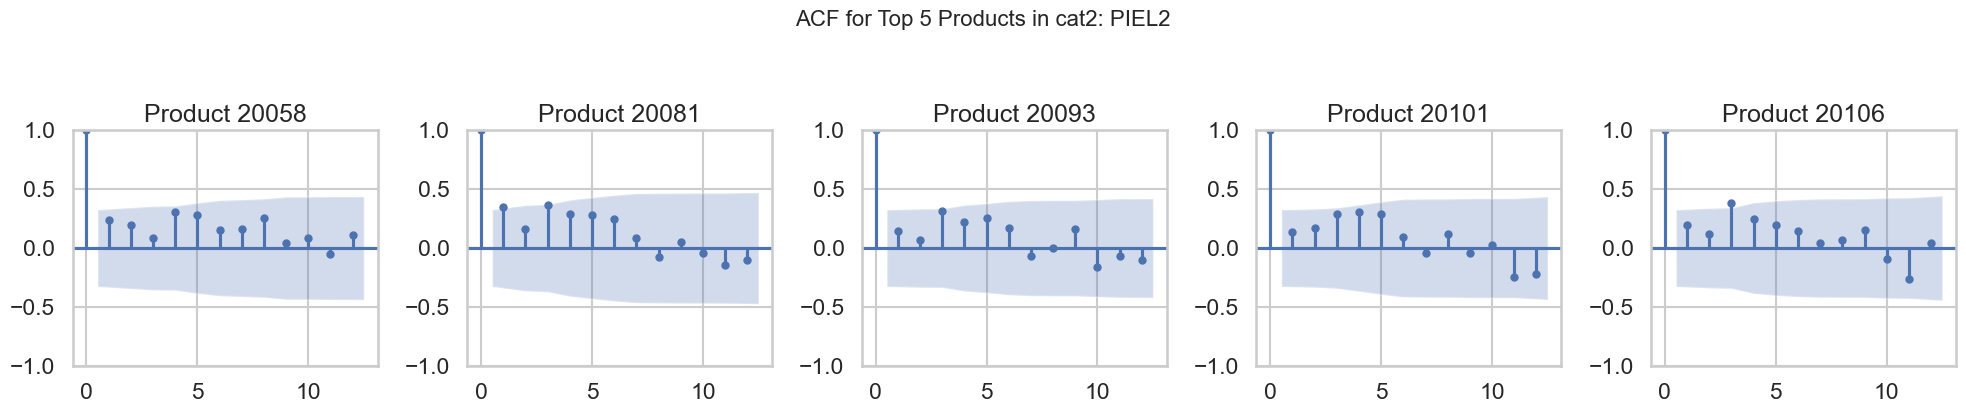

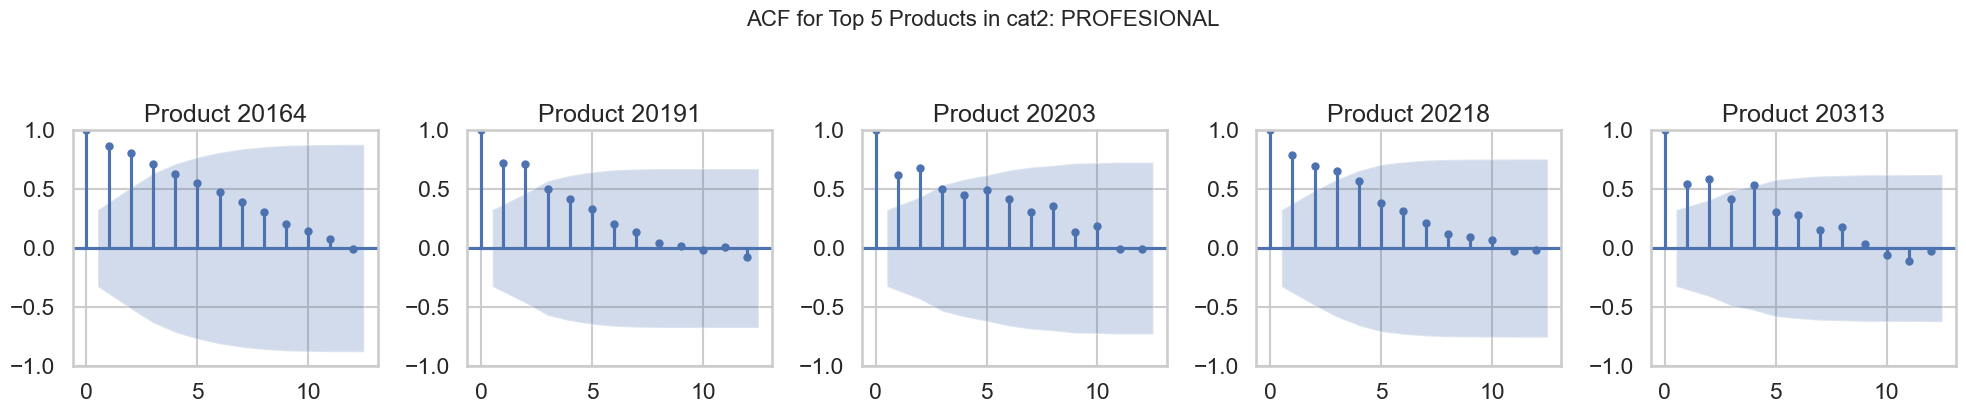

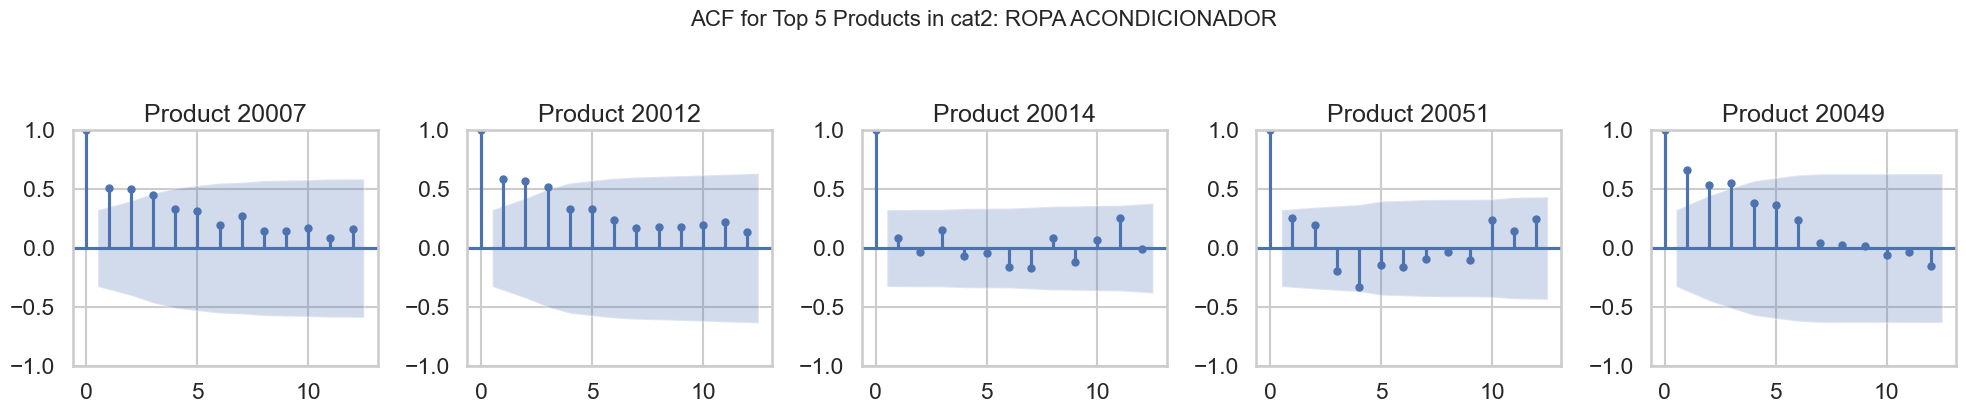

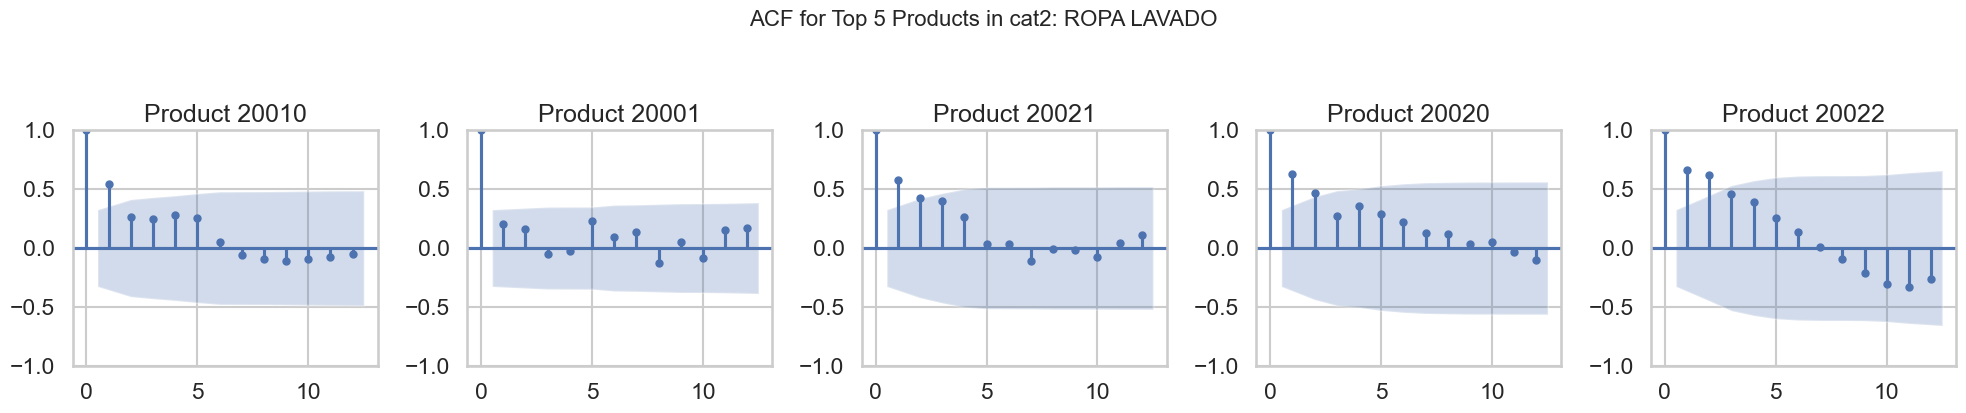

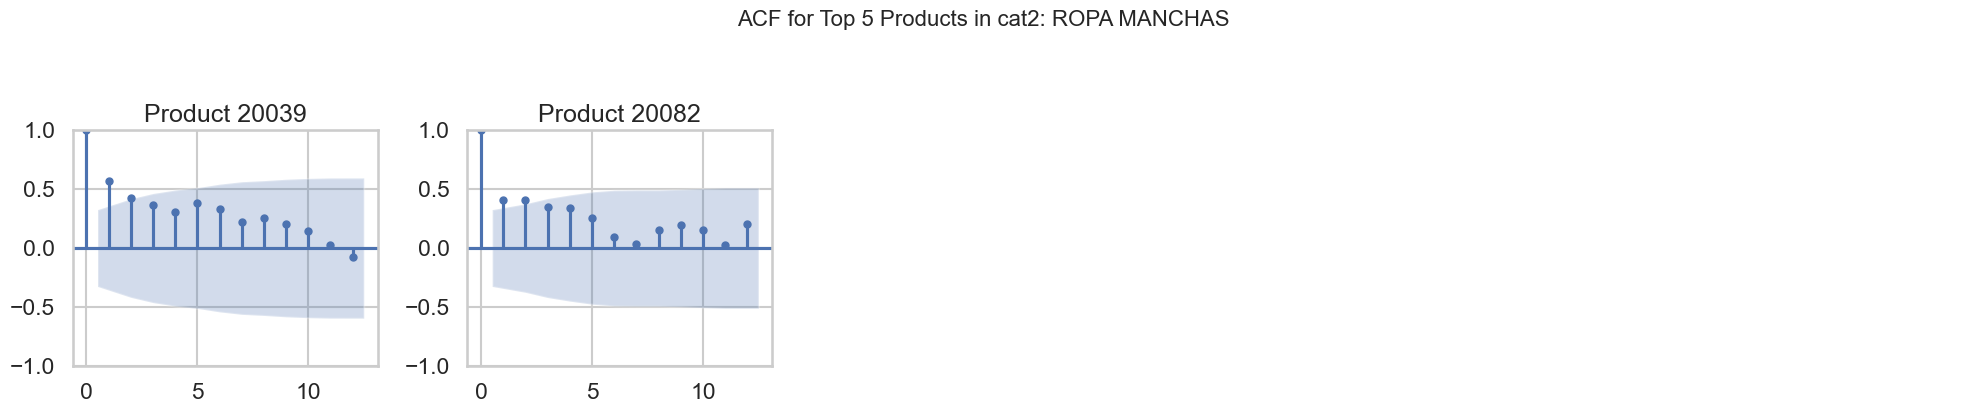

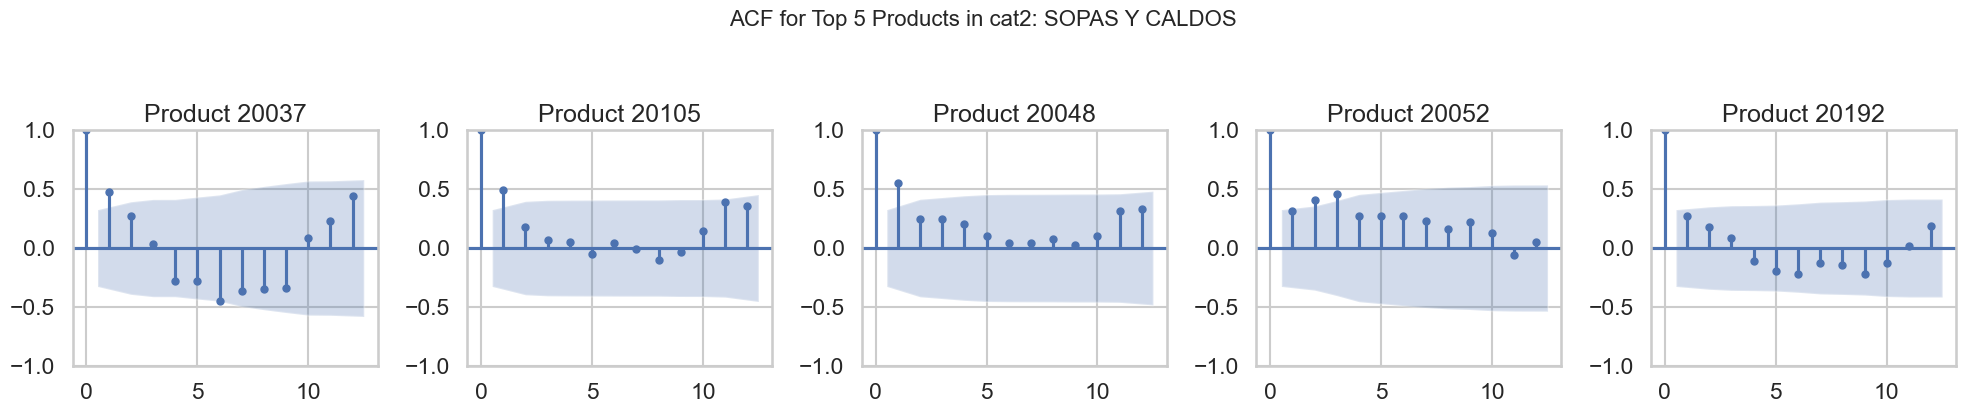

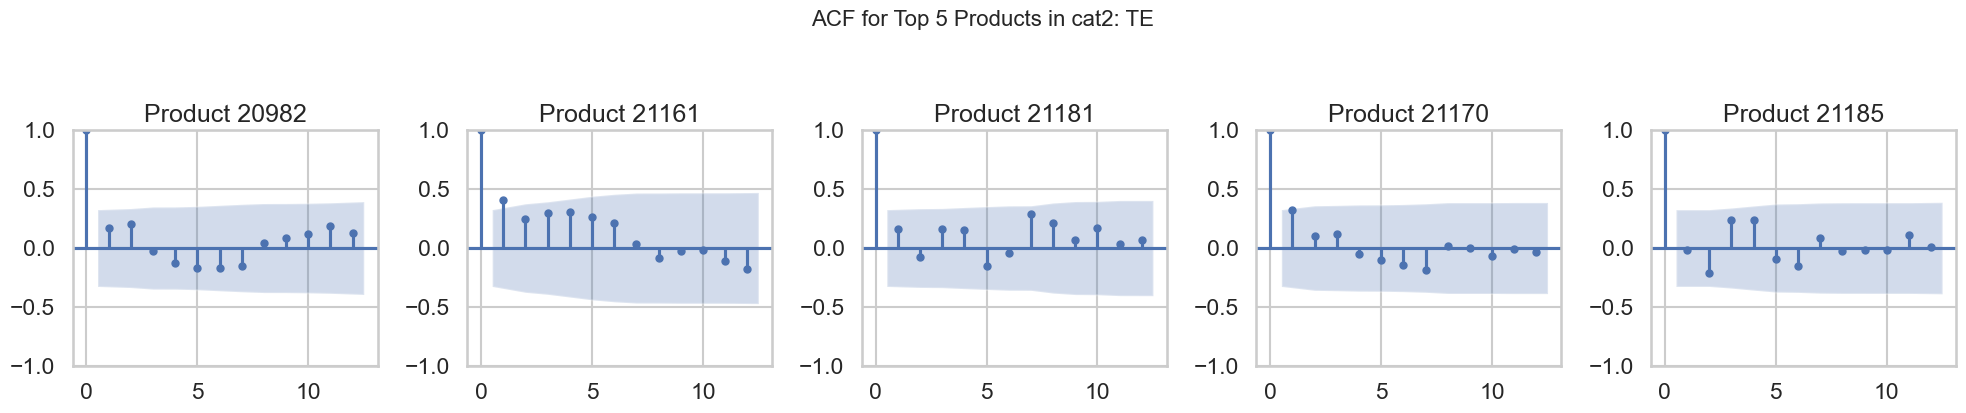

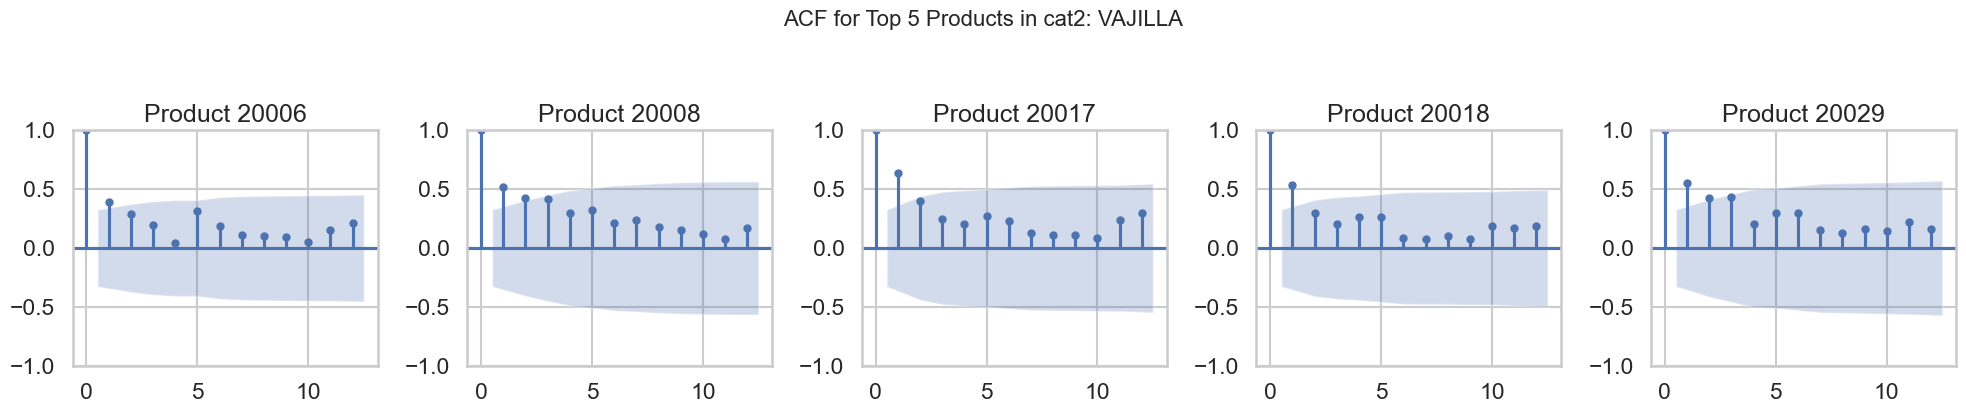

In [47]:
# Autocorrelation for products of each category

# Step 1: Aggregate monthly sales per product
monthly_sales = data.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# Step 2: Merge with cat2 info
monthly_sales = monthly_sales.merge(product_info[['product_id', 'cat2']], on='product_id', how='left')

# Step 3: Identify top 5 products by total sales per cat2
top_5_per_cat2 = (
    monthly_sales.groupby(['cat2', 'product_id'])['tn']
    .sum()
    .reset_index()
    .sort_values(['cat2', 'tn'], ascending=[True, False])
    .groupby('cat2')
    .head(5)
)

# Step 4: Loop over each cat2 and plot ACF for its top 5 products
cat2_list = top_5_per_cat2['cat2'].unique()

for cat2 in cat2_list:
    top_products = top_5_per_cat2[top_5_per_cat2['cat2'] == cat2]['product_id'].tolist()
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    
    for i, pid in enumerate(top_products):
        # Get time series for this product, reindexed to monthly frequency
        product_data = monthly_sales[monthly_sales['product_id'] == pid]
        product_series = (
            product_data.set_index('periodo')
            .resample('MS')['tn']
            .sum()
            .fillna(0)
            .reset_index(drop=True)
        )

        plot_acf(product_series, lags=12, ax=axes[i])
        axes[i].set_title(f'Product {pid}')

    # Turn off unused axes if less than 5
    for j in range(len(top_products), 5):
        axes[j].axis('off')

    fig.suptitle(f"ACF for Top 5 Products in cat2: {cat2}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

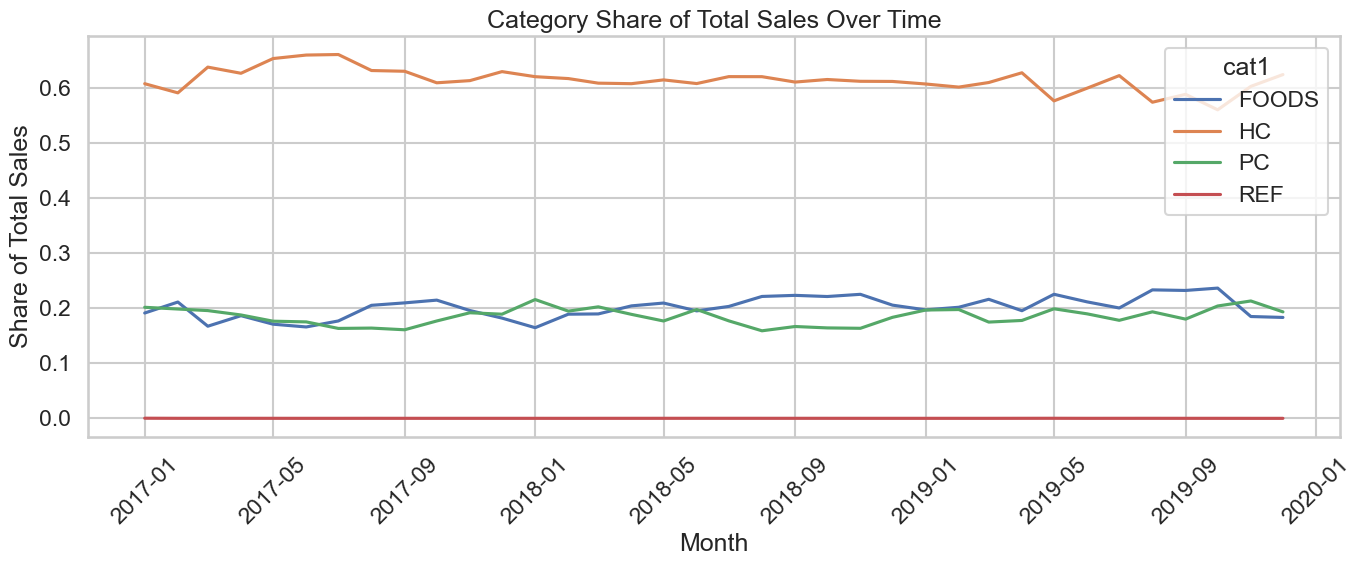

In [48]:
#Cat share over time

# Step 1: Aggregate total sales per period and category
monthly_cat_sales = data.groupby(['periodo', 'cat1'])['tn'].sum().reset_index()

# Step 2: Compute total sales per period
monthly_totals = monthly_cat_sales.groupby('periodo')['tn'].sum().reset_index(name='total_tn')

# Step 3: Merge to compute category share per period
monthly_cat_sales = monthly_cat_sales.merge(monthly_totals, on='periodo')
monthly_cat_sales['share'] = monthly_cat_sales['tn'] / monthly_cat_sales['total_tn']

# Step 4: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_cat_sales, x='periodo', y='share', hue='cat1')
plt.title("Category Share of Total Sales Over Time")
plt.ylabel("Share of Total Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


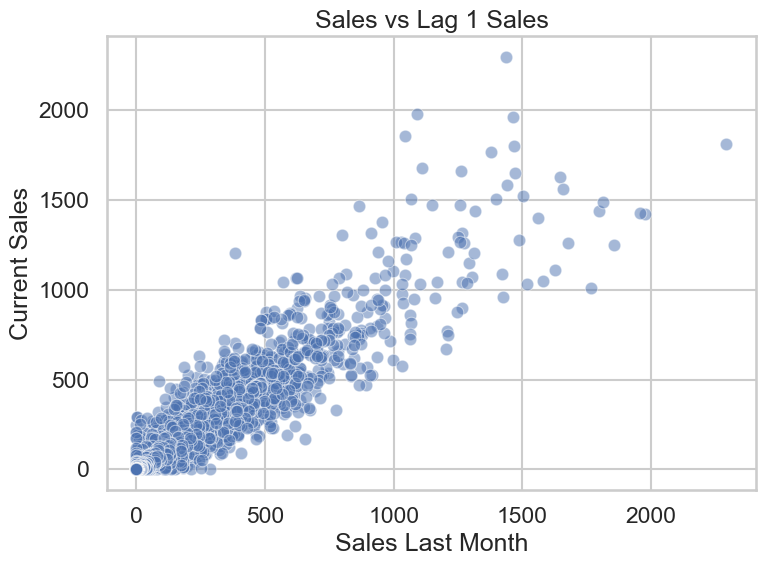

In [49]:
# Make sure data is sorted before creating lags
data = data.sort_values(['product_id', 'periodo'])

# Create lag_1 (previous month's sales per product)
data['lag_1'] = data.groupby('product_id')['tn'].shift(1)


lag_data = data[['tn', 'lag_1']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=lag_data, x='lag_1', y='tn', alpha=0.5)
plt.title("Sales vs Lag 1 Sales")
plt.xlabel("Sales Last Month")
plt.ylabel("Current Sales")
plt.tight_layout()
plt.show()


In [50]:
correlation = lag_data['tn'].corr(lag_data['lag_1'])
print(f"Pearson correlation between tn and lag_1: {correlation:.3f}")


Pearson correlation between tn and lag_1: 0.950


## Identificacion de productos estacionales, trending, o ninguno

In [51]:
from statsmodels.tsa.stattools import acf
from scipy.stats import linregress

def classify_product(pid, df):
    series = df[df['product_id'] == pid].sort_values('periodo')['tn'].reset_index(drop=True)
    
    if len(series) < 13:
        return 'unknown'  # not enough data
    
    # ACF
    acfs = acf(series, nlags=12, fft=True)
    lag1, lag3, lag12 = acfs[1], acfs[3], acfs[12]
    
    # Monthly variation (seasonality)
    monthly_avg = df[df['product_id'] == pid].groupby(df['periodo'].dt.month)['tn'].mean()
    std = monthly_avg.std()
    mean = monthly_avg.mean()
    cv = std / (mean + 1e-6)
    
    # Trend detection (linear slope over time)
    slope = linregress(range(len(series)), series)[0]
    
    # Rule-based classification
    if lag12 > 0.3 or cv > 0.5:
        return 'seasonal'
    elif lag1 > 0.5 and lag3 > 0.3 and lag12 < 0.2 and abs(slope) > 0.01:
        return 'trending'
    else:
        return 'neither'


In [52]:
# Aplico a todos los productos
product_ids = data['product_id'].unique()
classifications = {pid: classify_product(pid, data) for pid in product_ids}

# Convert to DataFrame
product_types = pd.DataFrame.from_dict(classifications, orient='index', columns=['pattern_type']).reset_index()
product_types.rename(columns={'index': 'product_id'}, inplace=True)


In [53]:
# Combino con el dataset original
data = data.merge(product_types, on='product_id', how='left')


In [54]:
print(data.head(), "\n \n")
print(data['pattern_type'].value_counts())

     periodo  product_id          tn  stock_final cat1         cat2     cat3  \
0 2017-01-01       20001   934.77222          NaN   HC  ROPA LAVADO  Liquido   
1 2017-02-01       20001   798.01620          NaN   HC  ROPA LAVADO  Liquido   
2 2017-03-01       20001  1303.35771          NaN   HC  ROPA LAVADO  Liquido   
3 2017-04-01       20001  1069.96130          NaN   HC  ROPA LAVADO  Liquido   
4 2017-05-01       20001  1502.20132          NaN   HC  ROPA LAVADO  Liquido   

   brand  sku_size  stockout  month       lag_1 pattern_type  
0  ARIEL    3000.0     False      1         NaN      neither  
1  ARIEL    3000.0     False      2   934.77222      neither  
2  ARIEL    3000.0     False      3   798.01620      neither  
3  ARIEL    3000.0     False      4  1303.35771      neither  
4  ARIEL    3000.0     False      5  1069.96130      neither   
 

pattern_type
neither     18144
seasonal    16992
trending     9648
Name: count, dtype: int64


## Top selling products

In [55]:
# Step 1: Aggregate total sales per product
top_selling = (
    data.groupby('product_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'tn': 'total_sales_tn'})
)

# Step 2: Merge with product_info to get cat1, cat2, cat3
top_selling = top_selling.merge(
    product_info[['product_id', 'cat1', 'cat2', 'cat3']],
    on='product_id',
    how='left'
)

# Step 3: Display top 30 products
top_selling.head(30)



product_id  total_sales_tn   cat1                 cat2            cat3
0        20001     50340.39558     HC          ROPA LAVADO         Liquido
1        20010     37342.15836     HC          ROPA LAVADO           Polvo
2        20010     37342.15836     HC          ROPA LAVADO           Polvo
3        20002     36337.25439     HC          ROPA LAVADO         Liquido
4        20003     32004.15274  FOODS             ADEREZOS        Mayonesa
5        20021     25003.78252     HC          ROPA LAVADO           Polvo
6        20021     25003.78252     HC          ROPA LAVADO           Polvo
7        20020     24516.78008     HC          ROPA LAVADO           Polvo
8        20020     24516.78008     HC          ROPA LAVADO           Polvo
9        20004     24178.15379  FOODS             ADEREZOS        Mayonesa
10       20005     23191.21852  FOODS             ADEREZOS        Mayonesa
11       20007     22018.45234     HC  ROPA ACONDICIONADOR  ACONDICIONADOR
12       20022     21387.99848     HC          ROPA LAVADO           Polvo
13       20022     21387.99848     HC          ROPA LAVADO           Polvo
14       20006     21088.76007     HC              VAJILLA      Cristalino
15       20008     19948.29352     HC              VAJILLA           Opaco
16       20012     17813.59935     HC  ROPA ACONDICIONADOR  ACONDICIONADOR
17       20009     16891.02429     HC          ROPA LAVADO         Liquido
18       20014     16177.73435     HC  ROPA ACONDICIONADOR  ACONDICIONADOR
19       20011     16085.40570     HC          ROPA LAVADO           Polvo
20       20013     15940.34442     HC                HOGAR         Cremoso
21       20015     14830.36374     HC          ROPA LAVADO         Liquido
22       20016     14351.40252     HC          ROPA LAVADO           Polvo
23       20019     13766.52294  FOODS             ADEREZOS        Mayonesa
24       20017     13495.98843     HC              VAJILLA           Opaco
25       20018     13178.80857     HC              VAJILLA      Cristalino
26       20037     12243.97840  FOODS       SOPAS Y CALDOS      Caldo Cubo
27       20037     12243.97840  FOODS       SOPAS Y CALDOS      Caldo Cubo
28       20024     10638.71172     HC          ROPA LAVADO           Polvo
29       20023     10435.28850  FOODS             ADEREZOS         Mostaza

In [56]:
data.head()

periodo  product_id          tn  stock_final cat1         cat2     cat3  \
0 2017-01-01       20001   934.77222          NaN   HC  ROPA LAVADO  Liquido   
1 2017-02-01       20001   798.01620          NaN   HC  ROPA LAVADO  Liquido   
2 2017-03-01       20001  1303.35771          NaN   HC  ROPA LAVADO  Liquido   
3 2017-04-01       20001  1069.96130          NaN   HC  ROPA LAVADO  Liquido   
4 2017-05-01       20001  1502.20132          NaN   HC  ROPA LAVADO  Liquido   

   brand  sku_size  stockout  month       lag_1 pattern_type  
0  ARIEL    3000.0     False      1         NaN      neither  
1  ARIEL    3000.0     False      2   934.77222      neither  
2  ARIEL    3000.0     False      3   798.01620      neither  
3  ARIEL    3000.0     False      4  1303.35771      neither  
4  ARIEL    3000.0     False      5  1069.96130      neither

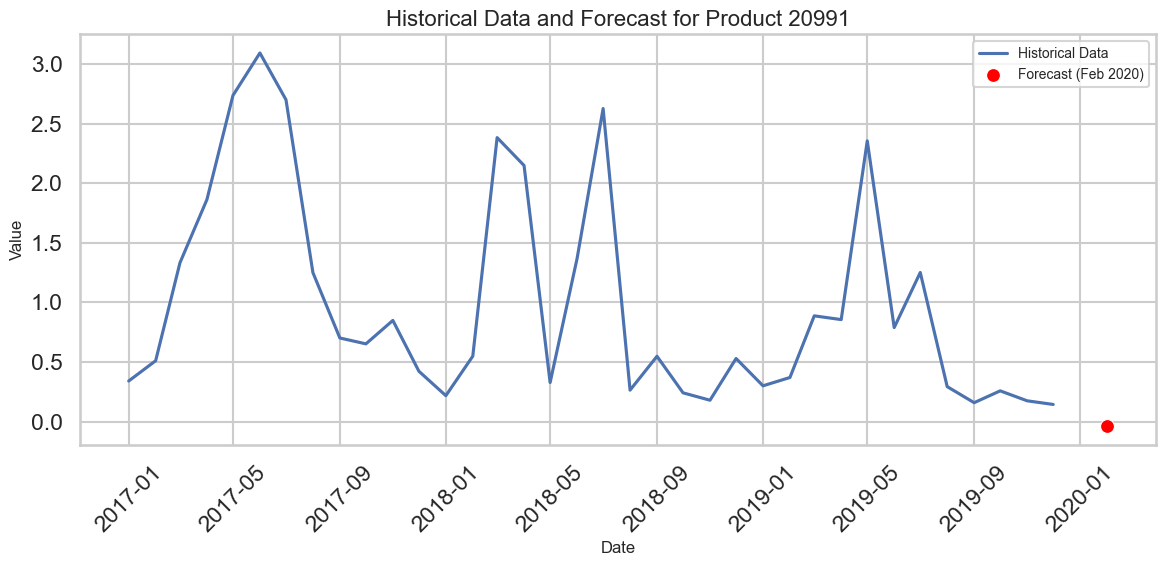

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_monthly = data  # Assuming 'data' is your DataFrame
predictions = pd.read_csv('../predictions/predictions_202002_0002.csv')

# Filter data for product 20991
product_data = data_monthly[data_monthly['product_id'] == 20991].copy()
product_forecast = predictions[predictions['product_id'] == 20991].iloc[0]

# Convert 'periodo' to datetime
product_data['periodo'] = pd.to_datetime(product_data['periodo'])

# Sort data by date
product_data = product_data.sort_values('periodo')

# Create a DataFrame for the forecast (only February 2020)
forecast_data = pd.DataFrame({
    'periodo': [pd.to_datetime('2020-02-01')],
    'tn': [product_forecast['tn']]  # Using 'tn' which represents tn_202002
})

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot historical data
sns.lineplot(x='periodo', y='tn', data=product_data, label='Historical Data')

# Plot forecast
sns.scatterplot(x='periodo', y='tn', data=forecast_data, label='Forecast (Feb 2020)', color='red', s=100)

# Customize the plot
plt.title(f'Historical Data and Forecast for Product 20991', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

